## Import required packages

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.impute import SimpleImputer
import itertools
import warnings
warnings.filterwarnings("ignore")

## Define functions to be used later

In [2]:
def standardize_columns(df):
    '''Function to convert column names of the imported dataframe to our standard'''
    
    if not len(df.columns) == 0 and len(df.columns) == 12:
        columns = list(df.columns)
        columns[0] = 'Person_ID'
        columns[1] = 'TPA_Claim_ID'
        columns[2] = 'Claim_Type'
        columns[3] = 'ICD_10'
        columns[4] = 'NDC_Name'
        columns[5] = 'Therapeutic_Class_Name'
        columns[6] = 'Days_Supply'
        columns[7] = 'Refills'
        columns[8] = 'Amount_Allowed'
        columns[9] = 'Plan'
        columns[10] = 'Start_Date'
        columns[11] = 'End_Date'
        df.columns = columns
    else:
        print("DataFrame is empty or does not have the correct number of columns.")
    
    return df

In [3]:
def validate_dtypes(df):
    '''Function to validate data types'''

    df = df.replace(',','', regex=True)

    str_cols = ['TPA_Claim_ID', 'Claim_Type', 'ICD_10', 'NDC_Name', 'Therapeutic_Class_Name']
    date_cols = ['Start_Date', 'End_Date']
    int_cols = ['Person_ID', 'Days_Supply', 'Refills']
    numeric_cols = ['Amount_Allowed']
    
    error_messages = []

    for col in str_cols:     
        valid_values = df[col].apply(lambda x: isinstance(x, str) or pd.isna(x))
        if not valid_values.all():
            error_messages.append(f"Column '{col}' contains values that are not strings or NaN.")
            

    for col in date_cols:
        try:
            pd.to_datetime(df[col], errors='raise')
        except (TypeError, ValueError):
            error_messages.append(f"Column '{col}' does not contain valid date values.")
            

    for col in int_cols:
        valid_values = df[col].apply(lambda x: isinstance(x, int))
        if not valid_values.all():
            error_messages.append(f"Column '{col}' contains values that are not integers.")
            

    for col in numeric_cols:
        valid_values = pd.to_numeric(df[col], errors='coerce').notnull()
        if not valid_values.all():
            error_messages.append(f"Column '{col}' contains values that are not numeric.")
          
    if not error_messages:
        print("All specified columns contain valid data types.")
    else:
        for message in error_messages:
            print(message)

In [4]:
def validate_claims(df):
    df.dropna(subset=['Claim_Type'], inplace=True)
    valid_values = df['Claim_Type'].str.lower().isin(['med', 'rx'])
    
    if valid_values.all():
        print("All values in the Claim_Type column are either 'MED' or 'Rx'.")
        
    else:
        print("The Claim_Type column contains values other than 'MED' or 'Rx'.")

In [5]:
def date_aggregate(df):
    ''' Function to aggregate the days supply and allowed amount for each date '''

    df = df.replace(',','', regex=True)
    df['Amount_Allowed'] = pd.to_numeric(df['Amount_Allowed'])
    df_grouped =  df.groupby('Start_Date').agg({'Days_Supply': 'sum', 'Amount_Allowed': 'sum'}).reset_index()
    df_trimmed = df.drop(['Days_Supply', 'Amount_Allowed'], axis=1).drop_duplicates('Start_Date')
    df = pd.merge(df_trimmed, df_grouped, on='Start_Date')
    
    # Only keep rows where aggregated days supply and aggregated amount allowed are both positive
    df = df[(df['Days_Supply'] > 0) & (df['Amount_Allowed'] > 0)]
    
    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    df['End_Date'] = pd.to_datetime(df['End_Date'])
    
    df.sort_values('Start_Date', inplace = True)
    df = df.reset_index(drop=True)
    
    df['Total_Amount_Allowed'] = df['Amount_Allowed'].sum()
   
    return df

In [6]:
# MPR is a measure of medication adherence based on pharmacy refill records
# A higher MPR means higher adherence
# An MPR >= 0.80 means an individual can be classed as adherent

def mpr(df):
    ''' Function to calculate Medication Possesseion Ratio (MPR) '''
    
    tot_med_supply = df.iloc[:-1]['Days_Supply'].sum()
    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    days_in_interval = (df['Start_Date'].iloc[-1] - df['Start_Date'].iloc[0]).days 
    res = np.round(tot_med_supply / days_in_interval, 2)
    df['Adherence_(MPR)'] = res
    # Capping MPR at 1.0
    df['Adherence_(MPR)'] = df['Adherence_(MPR)'].apply(lambda x: min(1, x))
    
    res_df = df[['Person_ID', 'TPA_Claim_ID', 'NDC_Name', 'Therapeutic_Class_Name', 'Total_Amount_Allowed', 'Adherence_(MPR)']].iloc[0].to_frame().transpose()
    res_df['Class'] = res_df['Adherence_(MPR)'].apply(lambda x: 'Adherent' if x >= 0.80 else 'Not Adherent')
    return res_df

In [7]:
def generate_mpr_results(df):
    ''' Function to generate a dataframe containing the MPR results for the Rx data'''

    unique_combinations = df[['Person_ID', 'NDC_Name']].drop_duplicates()
    res_df = pd.DataFrame()
    
    for idx, row in unique_combinations.iterrows():
        person_id = row['Person_ID']
        ndc_name = row['NDC_Name']
    
        subset_df = df[(df['Person_ID'] == person_id) & (df['NDC_Name'] == ndc_name)]
        agg_df = date_aggregate(subset_df)
    
        # This condition is needed to filter out single claims that will have an artificially high MPR of 1.0
        if len(agg_df) > 1:
            result = mpr(agg_df)
            res_df =  pd.concat([res_df, result], ignore_index=True)

    res_df['Expenditure'] = res_df['Total_Amount_Allowed'] * res_df['Adherence_(MPR)']
    res_df['Expenditure'] = res_df['Expenditure'].astype(float).round(2)
    res_df['Loss'] = res_df['Total_Amount_Allowed'] - res_df['Expenditure']
        

    return res_df

In [8]:
def cost_and_claims_per_month(df):
    ''' Function to compute cost and claim count per month per person'''
    
    df = df.replace(',','', regex=True)
    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    df['Year_Month'] = df['Start_Date'].dt.to_period('M')
    df['Amount_Allowed'] = pd.to_numeric(df['Amount_Allowed'])
    
    result_df = df.groupby(['Person_ID', 'Year_Month']).agg({'Amount_Allowed': 'sum', 'Start_Date': 'count'}).reset_index()
    result_df.columns = ['Person_ID', 'Year_Month', 'Total_Cost', 'Claim_Count']

    result_df.sort_values('Year_Month', inplace = True)
    result_df = result_df.reset_index(drop=True)
    
    
    return result_df

In [9]:
def calculate_preventive_claim_ratio(df):
    '''Function to calculate ratio of preventive claims to total claims'''
    
    df = df.replace(',','', regex=True)
    df['Amount_Allowed'] = pd.to_numeric(df['Amount_Allowed'])
    df = df[df['Amount_Allowed'] != 0]
    df['Year_Month'] = pd.to_datetime(df['Start_Date']).dt.to_period('M')
    
    agg_df = df.groupby('Year_Month')['Amount_Allowed'].sum().reset_index()
    df['Preventive'] = df['ICD_10'].str.lower().str.startswith("z", na=False)
    df['Not_Preventive'] = ~df['ICD_10'].str.lower().str.startswith("z", na=False)
    counts = df.groupby('Year_Month')[['Preventive', 'Not_Preventive']].sum().reset_index()
    
    agg_df = agg_df.merge(counts, on='Year_Month', how='left')
    agg_df['Total_Claims'] = agg_df['Preventive'] + agg_df['Not_Preventive']
    agg_df['Preventive_Claim_Ratio'] = agg_df['Preventive'] / agg_df['Total_Claims']
    
    return agg_df

In [10]:
def generate_wellness_data(med_df, employee_counts_df):
    '''Function to generate final wellness data dataframes'''
    
    wellness_df = calculate_preventive_claim_ratio(med_df)
    wellness_df = pd.merge(wellness_df, employee_counts_df)
    wellness_df['Cost_per_Claim'] = wellness_df['Amount_Allowed'] / wellness_df['Total_Claims']
    wellness_df['Cost_per_Employee'] = wellness_df['Amount_Allowed'] / wellness_df['Employee_Count'] 
    
    return wellness_df

In [11]:
def employee_count_by_plan(df):
    '''Function to calculate the total employee count for each plan'''

    melted_df = pd.melt(df, id_vars=['Plan', 'Plan_Type', 'Company_Coverage'], var_name='Year_Month', value_name='Employee_Count')

    result = melted_df.groupby(['Plan', 'Plan_Type', 'Year_Month'])['Employee_Count'].sum().reset_index()

    return result

In [12]:
# Read in data
Transient_df = pd.read_csv("data/Transient_med_and_rx.csv")
Quickway_df = pd.read_csv("data/Quickway_med_and_rx.csv")
Arnold_df = pd.read_csv("data/Arnold_med_and_rx.csv")
Dufresne_df = pd.read_csv("data/Dufresne_med_and_rx.csv")
Interstate_df = pd.read_csv("data/Interstate_med_and_rx.csv")
Paladin_df = pd.read_csv("data/Paladin_med_and_rx.csv")
TCI_df = pd.read_csv("data/TCI_med_and_rx.csv")
TeamSelect_df = pd.read_csv("data/TeamSelect_med_and_rx.csv")

In [13]:
Transient_df = standardize_columns(Transient_df)
Quickway_df = standardize_columns(Quickway_df)
Arnold_df = standardize_columns(Arnold_df)
Dufresne_df = standardize_columns(Dufresne_df)
Interstate_df = standardize_columns(Interstate_df)
Paladin_df = standardize_columns(Paladin_df)
TCI_df = standardize_columns(TCI_df)
TeamSelect_df = standardize_columns(TeamSelect_df)

In [14]:
# print(validate_dtypes(Transient_df))
# print(validate_dtypes(Quickway_df))
# print(validate_dtypes(Arnold_df))
# print(validate_dtypes(Dufresne_df))
# print(validate_dtypes(Interstate_df))
# print(validate_dtypes(Paladin_df))
# print(validate_dtypes(TCI_df))
# print(validate_dtypes(TeamSelect_df))

In [15]:
# print(validate_claims(Transient_df))
# print(validate_claims(Quickway_df))
# print(validate_claims(Arnold_df))
# print(validate_claims(Dufresne_df))
# print(validate_claims(Interstate_df))
# print(validate_claims(Paladin_df))
# print(validate_claims(TCI_df))
# print(validate_claims(TeamSelect_df))

In [16]:
# Read in data that contain plan types
Arnold_byPlan1 = pd.read_csv("data/Arnold_byPlan1.csv")
Arnold_byPlan2 = pd.read_csv("data/Arnold_byPlan2.csv")
Arnold_byPlan3 = pd.read_csv("data/Arnold_byPlan3.csv")
Arnold_byPlan1 = employee_count_by_plan(Arnold_byPlan1)
Arnold_byPlan2 = employee_count_by_plan(Arnold_byPlan2)
Arnold_byPlan3 = employee_count_by_plan(Arnold_byPlan3)
Arnold_byPlan = pd.concat([Arnold_byPlan1, Arnold_byPlan2, Arnold_byPlan3], ignore_index=True)

Interstate_byPlan1 = pd.read_csv("data/Interstate_byPlan1.csv")
Interstate_byPlan2 = pd.read_csv("data/Interstate_byPlan2.csv")
Interstate_byPlan3 = pd.read_csv("data/Interstate_byPlan3.csv")
Interstate_byPlan1 = employee_count_by_plan(Interstate_byPlan1)
Interstate_byPlan2 = employee_count_by_plan(Interstate_byPlan2)
Interstate_byPlan3 = employee_count_by_plan(Interstate_byPlan3)
Interstate_byPlan = pd.concat([Interstate_byPlan1, Interstate_byPlan2, Interstate_byPlan3], ignore_index=True)

Paladin_byPlan1 = pd.read_csv("data/Paladin_byPlan1.csv")
Paladin_byPlan2 = pd.read_csv("data/Paladin_byPlan2.csv")
Paladin_byPlan3 = pd.read_csv("data/Paladin_byPlan3.csv")
Paladin_byPlan1 = employee_count_by_plan(Paladin_byPlan1)
Paladin_byPlan2 = employee_count_by_plan(Paladin_byPlan2)
Paladin_byPlan3 = employee_count_by_plan(Paladin_byPlan3)
Paladin_byPlan = pd.concat([Paladin_byPlan1, Paladin_byPlan2, Paladin_byPlan3], ignore_index=True)

Quickway_byPlan1 = pd.read_csv("data/Quickway_byPlan1.csv")
Quickway_byPlan2 = pd.read_csv("data/Quickway_byPlan2.csv")
Quickway_byPlan1 = employee_count_by_plan(Quickway_byPlan1)
Quickway_byPlan2 = employee_count_by_plan(Quickway_byPlan2)
Quickway_byPlan = pd.concat([Quickway_byPlan1, Quickway_byPlan2], ignore_index=True)

TCI_byPlan = pd.read_csv("data/TCI_byPlan.csv")
TCI_byPlan = employee_count_by_plan(TCI_byPlan)

TeamSelect_byPlan1 = pd.read_csv("data/TeamSelect_byPlan1.csv")
TeamSelect_byPlan2 = pd.read_csv("data/TeamSelect_byPlan2.csv")
TeamSelect_byPlan3 = pd.read_csv("data/TeamSelect_byPlan3.csv")
TeamSelect_byPlan1 = employee_count_by_plan(TeamSelect_byPlan1)
TeamSelect_byPlan2 = employee_count_by_plan(TeamSelect_byPlan2)
TeamSelect_byPlan3 = employee_count_by_plan(TeamSelect_byPlan3)
TeamSelect_byPlan = pd.concat([TeamSelect_byPlan1, TeamSelect_byPlan2, TeamSelect_byPlan3], ignore_index=True)

Transient_byPlan1 = pd.read_csv("data/Transient_byPlan1.csv")
Transient_byPlan2 = pd.read_csv("data/Transient_byPlan2.csv")
Transient_byPlan3 = pd.read_csv("data/Transient_byPlan3.csv")
Transient_byPlan1 = employee_count_by_plan(Transient_byPlan1)
Transient_byPlan2 = employee_count_by_plan(Transient_byPlan2)
Transient_byPlan3 = employee_count_by_plan(Transient_byPlan3)
Transient_byPlan = pd.concat([Transient_byPlan1,Transient_byPlan2, Transient_byPlan3], ignore_index=True)


Dufresne_byPlan1 = pd.read_csv("data/Dufresne_byPlan1.csv") 
Dufresne_byPlan2 = pd.read_csv("data/Dufresne_byPlan2.csv")
Dufresne_byPlan3 = pd.read_csv("data/Dufresne_byPlan3.csv")
Dufresne_byPlan4 = pd.read_csv("data/Dufresne_byPlan4.csv")
Dufresne_byPlan1 = employee_count_by_plan(Dufresne_byPlan1)
Dufresne_byPlan2 = employee_count_by_plan(Dufresne_byPlan2)
Dufresne_byPlan3 = employee_count_by_plan(Dufresne_byPlan3)
Dufresne_byPlan4 = employee_count_by_plan(Dufresne_byPlan4)
Dufresne_byPlan = pd.concat([Dufresne_byPlan1, Dufresne_byPlan2, Dufresne_byPlan3, Dufresne_byPlan4], ignore_index=True)

In [17]:
# Join tables to add plan type to the master data frames

Arnold_plan_type_df = Arnold_byPlan[['Plan', 'Plan_Type']]
Arnold_df = Arnold_df.merge(Arnold_plan_type_df, on='Plan', how='left')
Transient_plan_type_df = Transient_byPlan[['Plan', 'Plan_Type']]
Transient_df = Transient_df.merge(Transient_plan_type_df, on='Plan', how='left')
Quickway_plan_type_df = Quickway_byPlan[['Plan', 'Plan_Type']]
Quickway_df = Quickway_df.merge(Quickway_plan_type_df, on='Plan', how='left')
Dufresne_plan_type_df = Dufresne_byPlan[['Plan', 'Plan_Type']]
Dufresne_df = Dufresne_df.merge(Dufresne_plan_type_df, on='Plan', how='left')
Interstate_plan_type_df = Interstate_byPlan[['Plan', 'Plan_Type']]
Interstate_df = Interstate_df.merge(Interstate_plan_type_df, on='Plan', how='left')
Paladin_plan_type_df = Paladin_byPlan[['Plan', 'Plan_Type']]
Paladin_df = Paladin_df.merge(Paladin_plan_type_df, on='Plan', how='left')
TCI_plan_type_df = TCI_byPlan[['Plan', 'Plan_Type']]
TCI_df = TCI_df.merge(TCI_plan_type_df, on='Plan', how='left')
TeamSelect_plan_type_df = TeamSelect_byPlan[['Plan', 'Plan_Type']]
TeamSelect_df = TeamSelect_df.merge(TeamSelect_plan_type_df, on='Plan', how='left')

In [18]:
# Separate Rx and Medical claims
Transient_rx_data = Transient_df[Transient_df["Claim_Type"] == "Rx"]
Transient_med_data = Transient_df[Transient_df["Claim_Type"] == "MED"]
Quickway_rx_data = Quickway_df[Quickway_df["Claim_Type"] == "Rx"]
Quickway_med_data = Quickway_df[Quickway_df["Claim_Type"] == "MED"]
Arnold_rx_data = Arnold_df[Arnold_df["Claim_Type"] == "Rx"]
Arnold_med_data = Arnold_df[Arnold_df["Claim_Type"] == "MED"]
Dufresne_rx_data = Dufresne_df[Dufresne_df["Claim_Type"] == "Rx"]
Dufresne_med_data = Dufresne_df[Dufresne_df["Claim_Type"] == "MED"]
Interstate_rx_data = Interstate_df[Interstate_df["Claim_Type"] == "Rx"]
Interstate_med_data = Interstate_df[Interstate_df["Claim_Type"] == "MED"]
Paladin_rx_data = Paladin_df[Paladin_df["Claim_Type"] == "Rx"]
Paladin_med_data = Paladin_df[Paladin_df["Claim_Type"] == "MED"]
TCI_rx_data = TCI_df[TCI_df["Claim_Type"] == "Rx"]
TCI_med_data = TCI_df[TCI_df["Claim_Type"] == "MED"]
TeamSelect_rx_data = TeamSelect_df[TeamSelect_df["Claim_Type"] == "Rx"]
TeamSelect_med_data = TeamSelect_df[TeamSelect_df["Claim_Type"] == "MED"]

In [19]:
# Generate MPR results
Transient_res_df = generate_mpr_results(Transient_rx_data)
Quickway_res_df = generate_mpr_results(Quickway_rx_data)
Arnold_res_df = generate_mpr_results(Arnold_rx_data)
Dufresne_res_df = generate_mpr_results(Dufresne_rx_data)
Interstate_res_df = generate_mpr_results(Interstate_rx_data)
Paladin_res_df = generate_mpr_results(Paladin_rx_data)
TCI_res_df = generate_mpr_results(TCI_rx_data)
TeamSelect_res_df = generate_mpr_results(TeamSelect_rx_data)

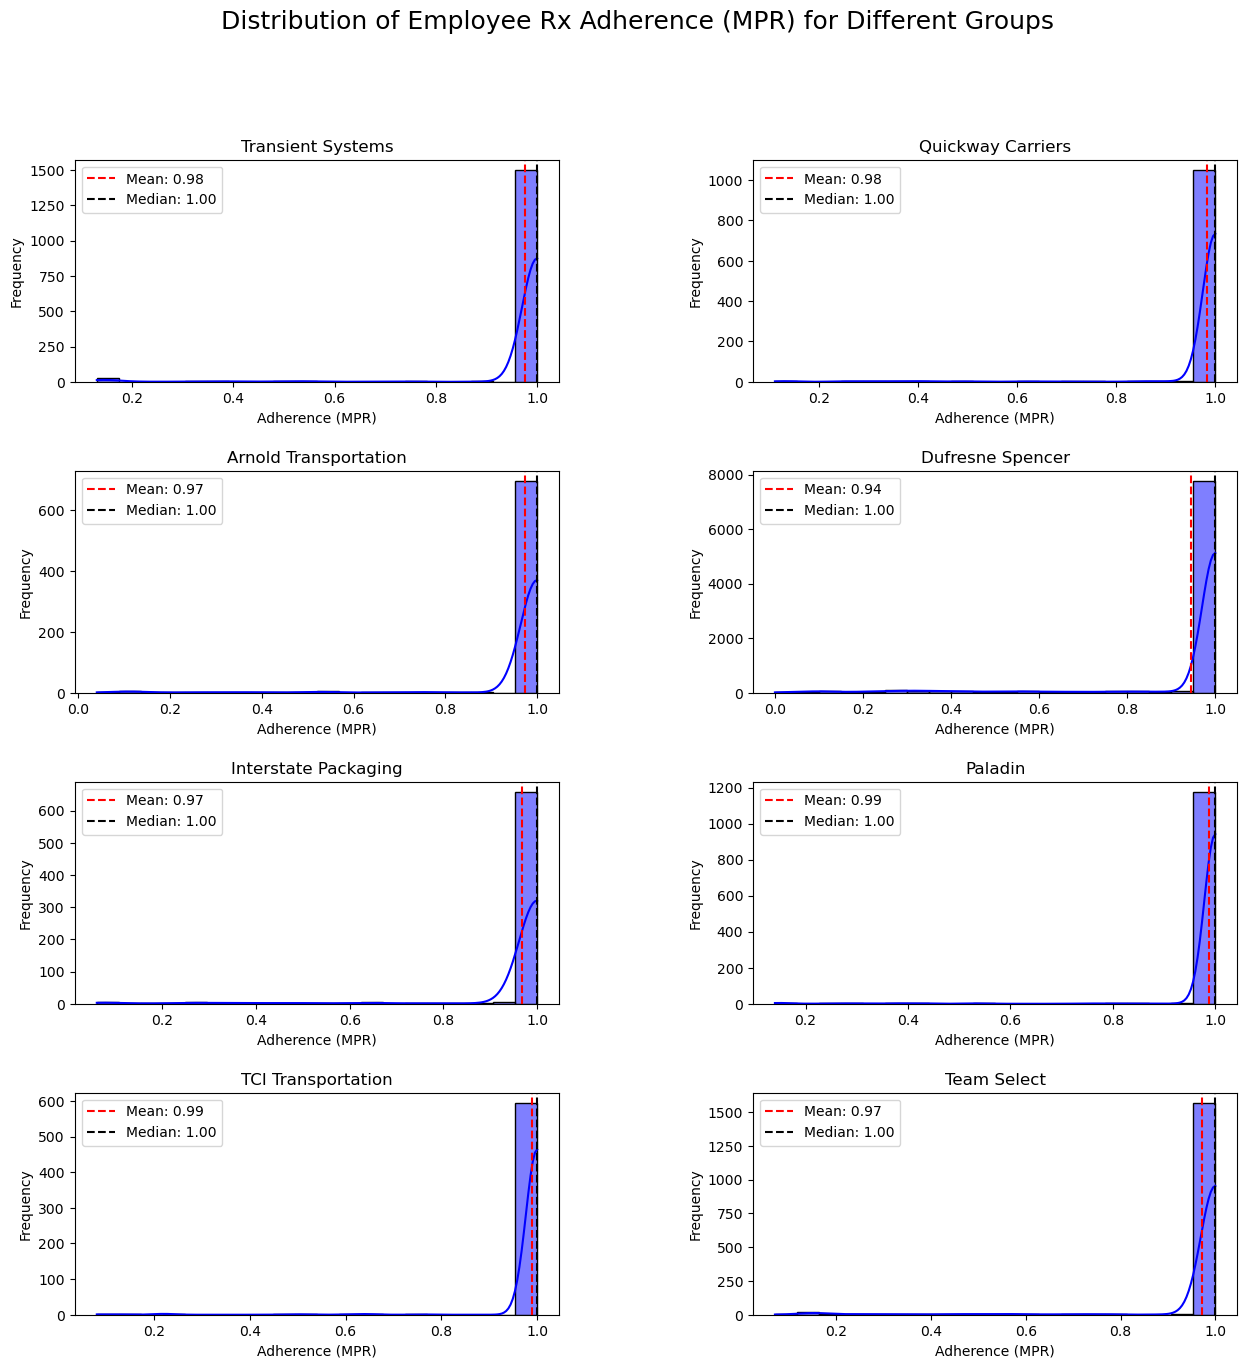

In [77]:
# Distribution of Rx Adherence (MPR)

data_frames = [Transient_res_df, Quickway_res_df, Arnold_res_df, Dufresne_res_df, Interstate_res_df, Paladin_res_df, TCI_res_df, TeamSelect_res_df]
titles = ['Transient Systems', 'Quickway Carriers', 'Arnold Transportation', 'Dufresne Spencer', 'Interstate Packaging', 'Paladin', 'TCI Transportation', 'Team Select']

rows = 4
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(15, 15), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})

for i, ax in enumerate(axs.flat):
    sns.histplot(data_frames[i]['Adherence_(MPR)'], bins=20, kde=True, color='blue', ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('Adherence (MPR)')
    ax.set_ylabel('Frequency')
    mean_adherence = data_frames[i]['Adherence_(MPR)'].mean()
    median_adherence = data_frames[i]['Adherence_(MPR)'].median()
    ax.axvline(mean_adherence, color='red', linestyle='--', label=f'Mean: {mean_adherence:.2f}')
    ax.axvline(median_adherence, color='black', linestyle='--', label=f'Median: {median_adherence:.2f}')
    ax.legend()

plt.suptitle('Distribution of Employee Rx Adherence (MPR) for Different Groups', fontsize=18)
plt.tight_layout()
plt.show()

In [21]:
# Read data for employee counts
Transient_EmployeeCounts = pd.read_csv('data/Transient_EmployeeCounts.csv')
Quickway_EmployeeCounts = pd.read_csv('data/Quickway_EmployeeCounts.csv')
Arnold_EmployeeCounts = pd.read_csv('data/Arnold_EmployeeCounts.csv')
Dufresne_EmployeeCounts = pd.read_csv('data/Dufresne_EmployeeCounts.csv')
Interstate_EmployeeCounts = pd.read_csv('data/Interstate_EmployeeCounts.csv')
Paladin_EmployeeCounts = pd.read_csv('data/Paladin_EmployeeCounts.csv')
TCI_EmployeeCounts = pd.read_csv('data/TCI_EmployeeCounts.csv')
TeamSelect_EmployeeCounts = pd.read_csv('data/TeamSelect_EmployeeCounts.csv')

In [22]:
Employee_Counts_list = [Transient_EmployeeCounts, Quickway_EmployeeCounts, Arnold_EmployeeCounts,
                        Dufresne_EmployeeCounts, Interstate_EmployeeCounts, Paladin_EmployeeCounts,
                        TCI_EmployeeCounts, TeamSelect_EmployeeCounts]

In [23]:
for df in Employee_Counts_list:
    df['Year_Month'] = pd.to_datetime(df['Year_Month']).dt.to_period('M')
    df['Employee_Count'] = pd.to_numeric(df['Employee_Count'], errors='coerce')

In [24]:
# Generate wellness data for all clients
Transient_wellness_df = generate_wellness_data(Transient_med_data, Transient_EmployeeCounts)
Transient_wellness_df['Firm'] = 'Transient Systems' 

In [25]:
Quickway_wellness_df = generate_wellness_data(Quickway_med_data, Quickway_EmployeeCounts)
Quickway_wellness_df['Firm'] = 'Quickway Carriers'

In [26]:
Arnold_wellness_df = generate_wellness_data(Arnold_med_data, Arnold_EmployeeCounts)
Arnold_wellness_df['Firm'] = 'Arnold Transportation'

In [27]:
Dufresne_wellness_df = generate_wellness_data(Dufresne_med_data, Dufresne_EmployeeCounts)
Dufresne_wellness_df['Firm'] = 'Dufresne Spencer'

In [28]:
Interstate_wellness_df = generate_wellness_data(Interstate_med_data, Interstate_EmployeeCounts)
Interstate_wellness_df['Firm'] = 'Interstate Packaging'

In [29]:
Paladin_wellness_df = generate_wellness_data(Paladin_med_data, Paladin_EmployeeCounts)
Paladin_wellness_df['Firm'] = 'Paladin'

In [30]:
TCI_wellness_df = generate_wellness_data(TCI_med_data, TCI_EmployeeCounts)
TCI_wellness_df['Firm'] = 'TCI Transportation'

In [31]:
TeamSelect_wellness_df = generate_wellness_data(TeamSelect_med_data, TeamSelect_EmployeeCounts)
TeamSelect_wellness_df['Firm'] = 'Team Select'

In [32]:
wellness_dfs = [Transient_wellness_df, Quickway_wellness_df, Arnold_wellness_df, Dufresne_wellness_df, Interstate_wellness_df, Paladin_wellness_df, TCI_wellness_df, TeamSelect_wellness_df]

In [33]:
for df in wellness_dfs:
    df.drop(df.index[-1], inplace=True)
    df['Amount_Allowed_6_month_avg'] = pd.to_numeric(df['Amount_Allowed'].rolling(window=6).mean(), errors='coerce')
    df['Preventive_Claim_Ratio_6_month_avg'] = pd.to_numeric(df['Preventive_Claim_Ratio'].rolling(window=6).mean(), errors='coerce')
    df['Cost_per_Claim_6_month_avg'] = pd.to_numeric(df['Cost_per_Claim'].rolling(window=6).mean(), errors='coerce')
    df['Cost_per_Employee_6_month_avg'] = pd.to_numeric(df['Cost_per_Employee'].rolling(window=6).mean(), errors='coerce')
    df['Cost_per_Claim_3_month_avg'] = pd.to_numeric(df['Cost_per_Claim'].rolling(window=3).mean(), errors='coerce')
    df['Cost_per_Employee_3_month_avg'] = pd.to_numeric(df['Cost_per_Employee'].rolling(window=3).mean(), errors='coerce')

In [34]:
all_wellness_df = pd.concat(wellness_dfs, ignore_index=True)
all_wellness_df['Year_Month'] = all_wellness_df['Year_Month'].dt.strftime('%Y-%m')
all_wellness_df.drop(all_wellness_df.index[-1], inplace=True)

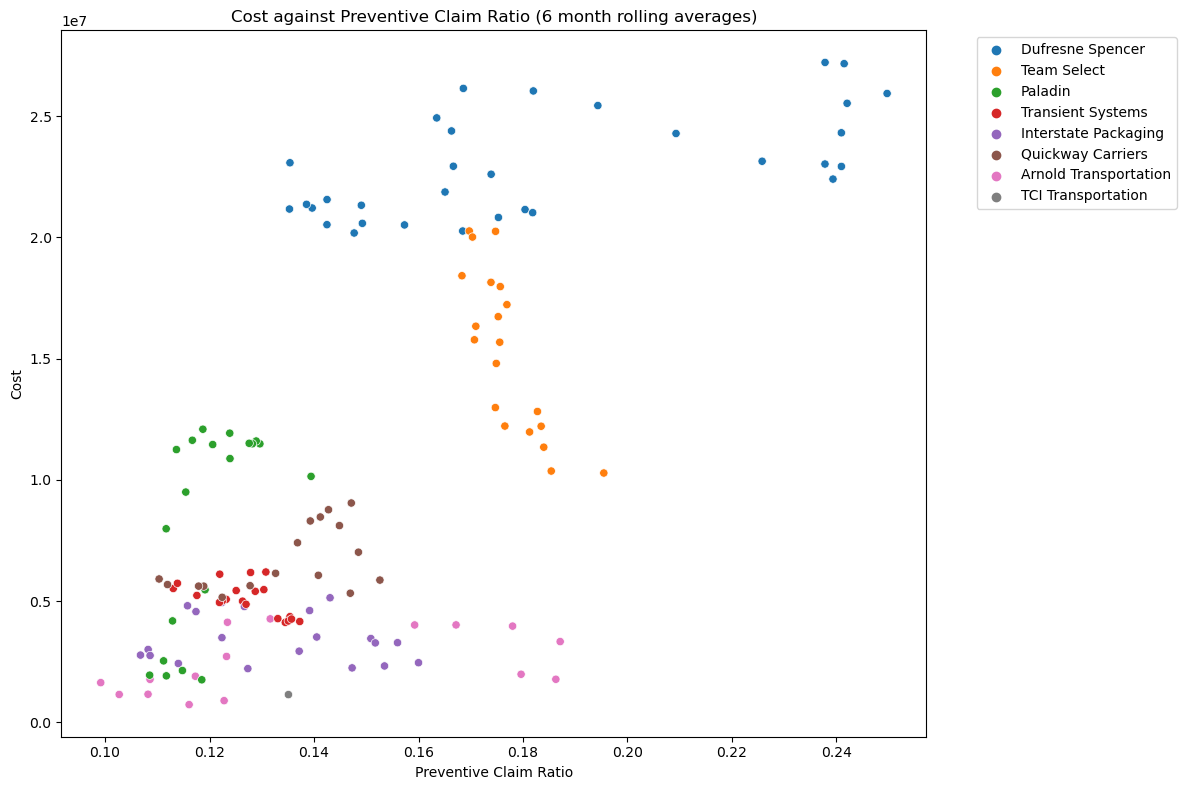

In [78]:
# Plotting Cost against PCR
plt.figure(figsize=(12, 8))
sns.scatterplot(data=all_wellness_df, x='Preventive_Claim_Ratio_6_month_avg', y='Amount_Allowed_6_month_avg', hue='Firm', palette='tab10')
plt.title('Cost against Preventive Claim Ratio (6 month rolling averages)')
plt.xlabel('Preventive Claim Ratio')
plt.ylabel('Cost')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

## Classification Model: K-Means

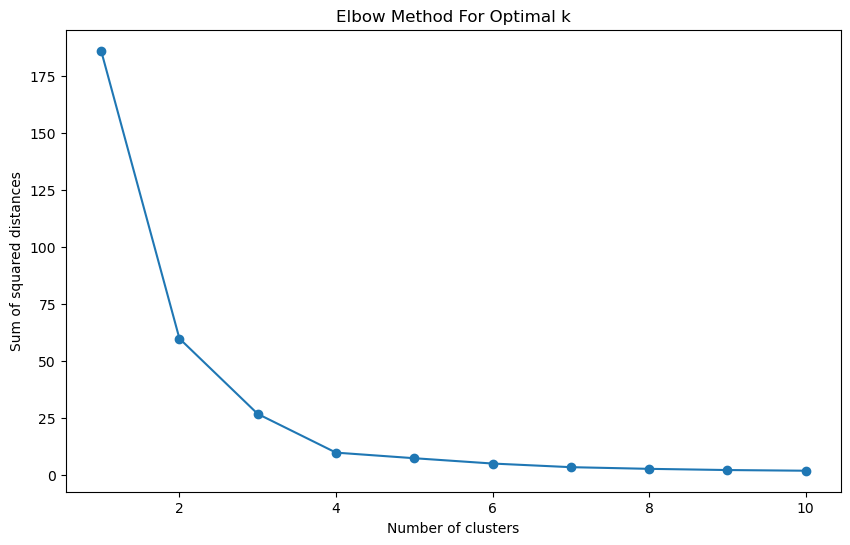

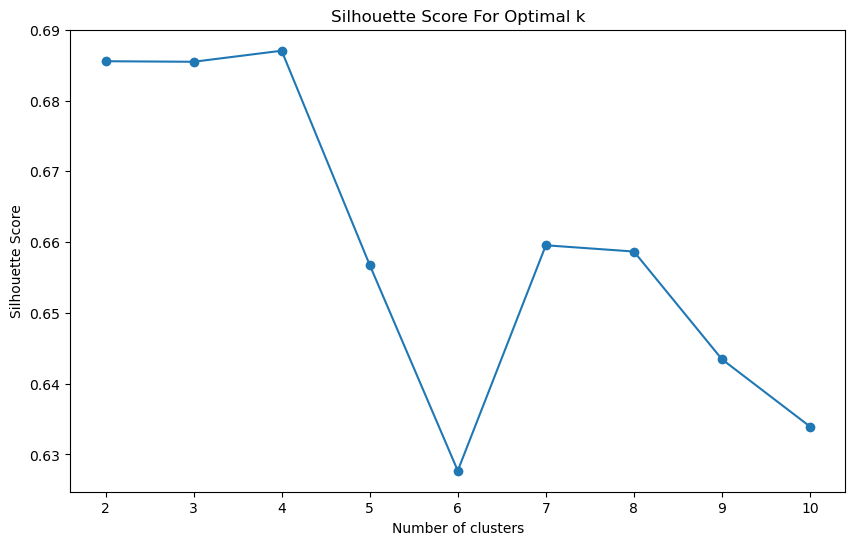

In [53]:
# Handle NaN values using median imputation
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(all_wellness_df[['Preventive_Claim_Ratio_6_month_avg']])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

# Silhouette Scores
silhouette_scores = []
for k in range(2, 11):  # silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_scores.append(silhouette_score(data_scaled, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


Silhouette Score for k=4: 0.69
Cluster                 0   1   2   3
Firm                                 
Arnold Transportation   6   9   0   6
Dufresne Spencer       15   0  10  12
Interstate Packaging   14  10   0   1
Paladin                 7  18   0   0
Quickway Carriers      16   6   0   0
TCI Transportation      6   0   0   0
Team Select             5   0   0  20
Transient Systems      13  12   0   0


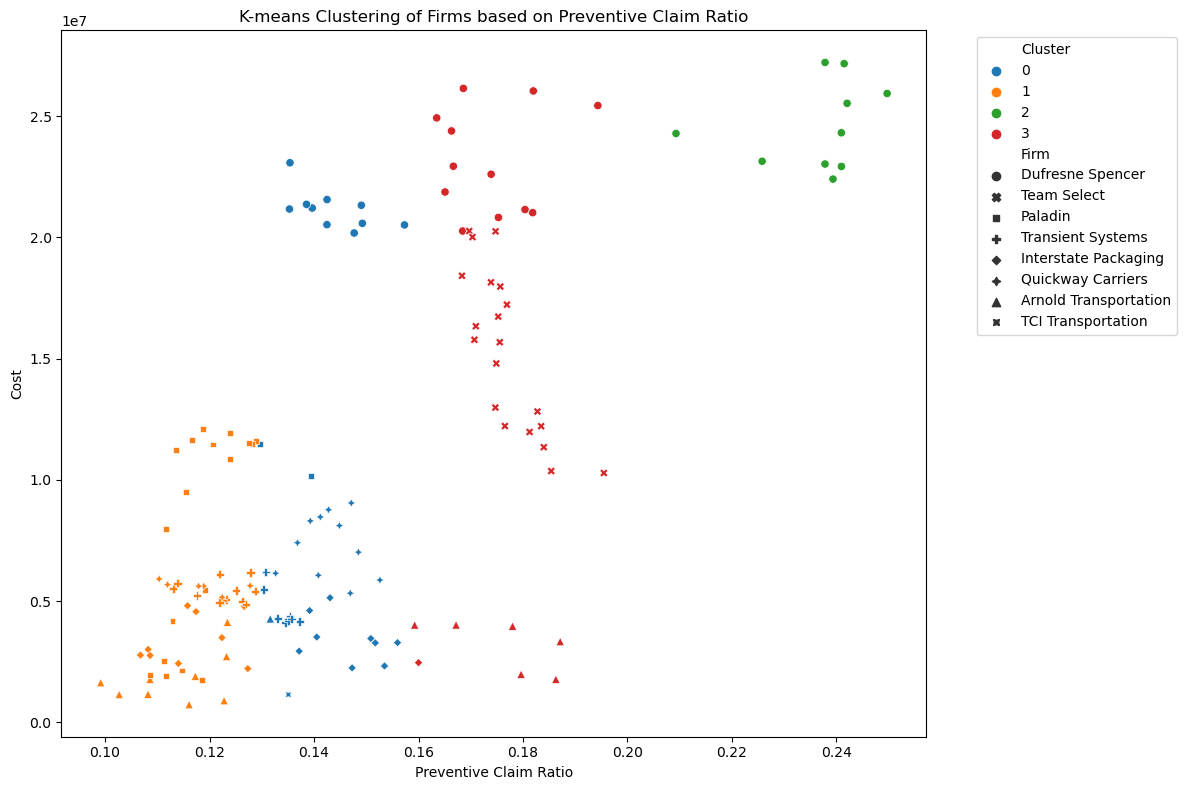

In [74]:
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(all_wellness_df[['Preventive_Claim_Ratio_6_month_avg']])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
all_wellness_df['Cluster'] = kmeans.fit_predict(data_scaled)

# Evaluate with silhouette score
silhouette_avg = np.round(silhouette_score(data_scaled, all_wellness_df['Cluster']), 2)

print(f'Silhouette Score for k={optimal_k}: {silhouette_avg}')

# Cross-tabulation with actual groups
cross_tab = pd.crosstab(all_wellness_df['Firm'], all_wellness_df['Cluster'])
print(cross_tab)

# Visualize Clusters with Firms
plt.figure(figsize=(12, 8))
sns.scatterplot(data=all_wellness_df, x='Preventive_Claim_Ratio_6_month_avg', y='Amount_Allowed_6_month_avg', hue='Cluster', style='Firm', palette='tab10')
plt.title('K-means Clustering of Firms based on Preventive Claim Ratio')
plt.xlabel('Preventive Claim Ratio')
plt.ylabel('Cost')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

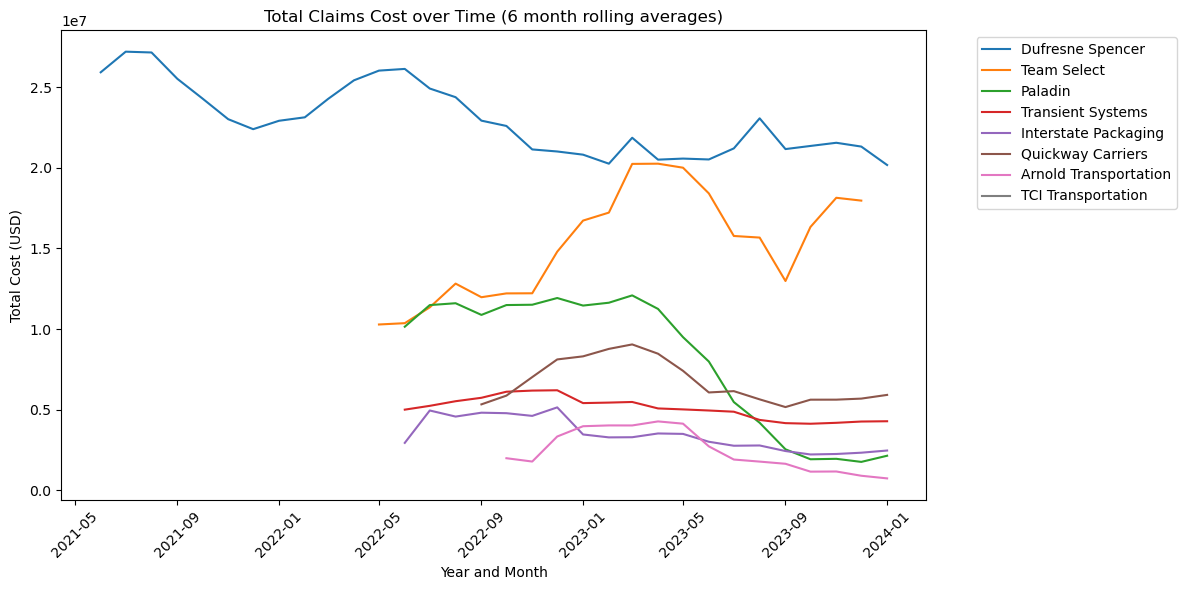

In [75]:
all_wellness_df['Year_Month'] = pd.to_datetime(all_wellness_df['Year_Month'])
all_wellness_df = all_wellness_df.sort_values(by='Year_Month')
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_wellness_df, x='Year_Month', y='Amount_Allowed_6_month_avg', hue='Firm', palette='tab10')
plt.title('Total Claims Cost over Time (6 month rolling averages)')
plt.xlabel('Year and Month')
plt.ylabel('Total Cost (USD)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [37]:
dufresne_tsa = all_wellness_df[all_wellness_df['Firm'] == 'Dufresne Spencer']
relevant_columns = ['Year_Month', 'Preventive_Claim_Ratio_6_month_avg', 'Amount_Allowed_6_month_avg']
dufresne_tsa = dufresne_tsa[relevant_columns]
dufresne_tsa['Year_Month'] = pd.to_datetime(dufresne_tsa['Year_Month'])
dufresne_tsa = dufresne_tsa.sort_values('Year_Month')
dufresne_tsa.dropna(inplace=True)

In [48]:
# Split data into train and test sets
train_size = 0.8  # 80% of data for training
train, test = train_test_split(dufresne_tsa, train_size=train_size, shuffle=False)

# Optional: Reset index for train and test sets
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Hyperparameter optimization for ARIMA
best_aic = float('inf')
best_arima_order = None
for p, d, q in itertools.product(range(3), range(2), range(3)):
    try:
        model = ARIMA(train['Amount_Allowed_6_month_avg'], order=(p, d, q), exog=train['Preventive_Claim_Ratio_6_month_avg'])
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_arima_order = (p, d, q)
    except:
        continue

# Hyperparameter optimization for SARIMAX
best_sarimax_aic = float('inf')
best_sarimax_order = None
for p, d, q, P, D, Q in itertools.product(range(3), range(2), range(3), range(3), range(2), range(3)):
    try:
        model = SARIMAX(train['Amount_Allowed_6_month_avg'], order=(p, d, q), seasonal_order=(P, D, Q, 12),
                        exog=train['Preventive_Claim_Ratio_6_month_avg'])
        results = model.fit()
        aic = results.aic
        if aic < best_sarimax_aic:
            best_sarimax_aic = aic
            best_sarimax_order = (p, d, q, P, D, Q)
    except:
        continue

# Train ARIMA model with optimal parameters
arima_model = ARIMA(train['Amount_Allowed_6_month_avg'], order=best_arima_order, exog=train['Preventive_Claim_Ratio_6_month_avg'])
arima_fit = arima_model.fit()

# Train SARIMAX model with optimal parameters
sarimax_model = SARIMAX(train['Amount_Allowed_6_month_avg'], order=(best_sarimax_order[0], best_sarimax_order[1], best_sarimax_order[2]), 
                        seasonal_order=(best_sarimax_order[3], best_sarimax_order[4], best_sarimax_order[5], 12),
                        exog=train['Preventive_Claim_Ratio_6_month_avg'])
sarimax_fit = sarimax_model.fit()

# Model Evaluation
# ARIMA
arima_forecast = arima_fit.forecast(steps=len(test), exog=test['Preventive_Claim_Ratio_6_month_avg'])
arima_rmse = np.sqrt(mean_squared_error(test['Amount_Allowed_6_month_avg'], arima_forecast))
arima_relative_rmse = arima_rmse / np.mean(test['Amount_Allowed_6_month_avg'])

# SARIMAX
sarimax_forecast = sarimax_fit.forecast(steps=len(test), exog=test['Preventive_Claim_Ratio_6_month_avg'])
sarimax_rmse = np.sqrt(mean_squared_error(test['Amount_Allowed_6_month_avg'], sarimax_forecast))
sarimax_relative_rmse = sarimax_rmse / np.mean(test['Amount_Allowed_6_month_avg'])


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76223D+01    |proj g|=  5.43637D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.436D-08   1.762D+01
  F =   17.622266470847915     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.31267D+00    |proj g|=  2.45255D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     39      1     0     0   8.734D-06   8.313D+00
  F =   8.3126574355052600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34805D+00    |proj g|=  8.16421D-01

At iterate    5    f=  8.23854D+00    |proj g|=  2.63237D-03

At iterate   10    f=  8.23854D+00    |proj g|=  9.56267D-04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65439D+01    |proj g|=  2.44419D-01

At iterate    5    f=  1.64835D+01    |proj g|=  3.65432D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   3.654D-06   1.648D+01
  F =   16.483497200889275     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.24938D+00    |proj g|=  4.21025D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   2.042D-06   8.249D+00
  F =   8.2493767954698978     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34455D+00    |proj g|=  7.61993D-01

At iterate    5    f=  8.24569D+00    |proj g|=  3.04977D-01

At iterate   10    f=  8.24310D+00    |proj g|=  7.57325D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.61550D+01    |proj g|=  7.84593D-03

At iterate   10    f=  1.61546D+01    |proj g|=  1.43473D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   6.096D-07   1.615D+01
  F =   16.154587308728193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34410D+00    |proj g|=  9.32188D-01

At iterate    5    f=  8.22689D+00    |proj g|=  3.13882D-07

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.61552D+01    |proj g|=  1.71134D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   1.711D-06   1.616D+01
  F =   16.155183345187865     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64955D+01    |proj g|=  9.58109D-01

At iterate    5    f=  1.61557D+01    |proj g|=  8.00754D-03

At iterate   10    f=  1.61552D+01    |proj g|=  9.64384D-06

       

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     38      1     0     0   3.161D-04   8.136D+00
  F =   8.1363063773533426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65451D+01    |proj g|=  9.38460D-01

At iterate    5    f=  1.61571D+01    |proj g|=  2.59595D-02

At iterate   10    f=  1.61546D+01    |proj g|=  1.22538D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.61546D+01    |proj g|=  3.06024D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     10     11      1     0     0   3.060D-05   1.615D+01
  F =   16.154586621704038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34410D+00    |proj g|=  9.32188D-01

At iterate    5    f=  8.13572D+00    |proj g|=  2.84272D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34410D+00    |proj g|=  9.32188D-01

At iterate    5    f=  8.13708D+00    |proj g|=  4.61295D-02

At iterate   10    f=  8.13589D+00    |proj g|=  2.37678D-03

At iterate   15    f=  8.13575D+00    |proj g|=  8.98505D-03

At iterate   20    f=  8.13573D+00    |proj g|=  7.05790D-04


 This problem is unconstrained.



At iterate   25    f=  8.13572D+00    |proj g|=  3.74244D-03

At iterate   30    f=  8.13571D+00    |proj g|=  1.12402D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     39      1     0     0   1.124D-04   8.136D+00
  F =   8.1357140795777170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65149D+01    |proj g|=  1.14890D+00

At iterate    5    f=  1.60188D+01    |proj g|=  8.02334D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38460D+00    |proj g|=  1.37973D+00

At iterate    5    f=  8.20709D+00    |proj g|=  1.58060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   3.039D-06   8.207D+00
  F =   8.2069814570579318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.60188D+01    |proj g|=  1.11142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     10      1     0     0   3.791D-07   1.602D+01
  F =   16.018783189863921     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65149D+01    |proj g|=  1.14890D+00

At iterate    5    f=  1.60188D+01    |proj g|=  9.99649D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.05304D+00    |proj g|=  7.27857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     21      1     0     0   1.645D-03   8.053D+00
  F =   8.0530162450880489     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65608D+01    |proj g|=  1.12534D+00

At iterate    5    f=  1.60187D+01    |proj g|=  2.92939D-03

At iterate   10    f=  1.60187D+01    |proj g|=  8.17906D-06

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.60187D+01    |proj g|=  5.35552D-03

At iterate   10    f=  1.60187D+01    |proj g|=  3.07914D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     10     12      1     0     0   3.079D-06   1.602D+01
  F =   16.018675391723445     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65149D+01    |proj g|=  1.14890D+00

At iterate    5    f=  1.60187D+01    |proj g|=  3.41014D-03

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38460D+00    |proj g|=  1.37973D+00

At iterate    5    f=  8.06048D+00    |proj g|=  1.77438D-01

At iterate   10    f=  8.05234D+00    |proj g|=  1.08544D-02

At iterate   15    f=  8.05232D+00    |proj g|=  1.50960D-03

At iterate   20    f=  8.05231D+00    |proj g|=  4.01696D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     37      1     0     0   5.573D-05   8.052D+00
  F =   8.0523075376265645     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  8.05231D+00    |proj g|=  2.58714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     38      1     0     0   3.161D-04   8.052D+00
  F =   8.0523110031562410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56053D+01    |proj g|=  2.05000D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     20      1     0     0   6.375D-05   1.455D+01
  F =   14.553950610528837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73207D+00    |proj g|=  1.15995D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45511D+01    |proj g|=  1.69453D-01

At iterate   10    f=  1.45491D+01    |proj g|=  3.61432D-02

At iterate   15    f=  1.45488D+01    |proj g|=  1.26190D-02

At iterate   20    f=  1.45488D+01    |proj g|=  2.06265D-03

At iterate   25    f=  1.45487D+01    |proj g|=  1.68310D-03

At iterate   30    f=  1.45486D+01    |proj g|=  6.16269D-04

At iterate   35    f=  1.45484D+01    |proj g|=  3.46880D-04

At iterate   40    f=  1.45479D+01    |proj g|=  2.38943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     50      1     0     0   8.419D-06   1.455D+01
  F =   14.5477998213

 This problem is unconstrained.



At iterate   20    f=  7.31331D+00    |proj g|=  3.47921D-02

At iterate   25    f=  7.31302D+00    |proj g|=  1.14222D-02

At iterate   30    f=  7.31292D+00    |proj g|=  1.29090D-02

At iterate   35    f=  7.31283D+00    |proj g|=  3.85339D-03

At iterate   40    f=  7.31282D+00    |proj g|=  5.76812D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     77      2     0     0   6.148D-05   7.313D+00
  F =   7.3128184786537727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45491D+01    |proj g|=  5.83661D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



At iterate   20    f=  7.31197D+00    |proj g|=  3.28581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     38      1     0     0   3.286D-03   7.312D+00
  F =   7.3119664017975348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36241D+00    |proj g|=  4.14292D-01

At iterate    5    f=  7.31101D+00    |proj g|=  3.25805D-01

At iterate   10    f=  7.31005D+00    |proj g|=  8.84278D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  7.30808D+00    |proj g|=  2.46875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     35      1     0     0   5.859D-03   7.308D+00
  F =   7.3080439242896862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48890D+01    |proj g|=  6.59452D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.25724D+00    |proj g|=  1.04023D-01

At iterate   10    f=  7.24637D+00    |proj g|=  6.80326D-02

At iterate   15    f=  7.24468D+00    |proj g|=  1.81274D-02

At iterate   20    f=  7.24463D+00    |proj g|=  4.71071D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     44      2     0     0   4.711D-05   7.245D+00
  F =   7.2446267372435962     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.45166D+01    |proj g|=  9.21752D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   9.218D-07   1.452D+01
  F =   14.516579021788647     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48890D+01    |proj g|=  6.59452D+00

At iterate    5    f=  1.45166D+01    |proj g|=  6.93446D-03

At iterate   10    f=  1.45158D+01    |proj g|=  2.03825D-01

At itera

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45143D+01    |proj g|=  3.07329D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     20      1     0     0   3.073D-04   1.451D+01
  F =   14.514335908214264     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29636D+00    |proj g|=  1.58276D+01

At iterate    5    f=  7.26205D+00    |proj g|=  6.32421D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   30    f=  7.24389D+00    |proj g|=  1.30352D-02

At iterate   35    f=  7.24387D+00    |proj g|=  4.03723D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     51      1     0     0   4.037D-04   7.244D+00
  F =   7.2438725004352742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48890D+01    |proj g|=  6.59452D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     19      1     0     0   1.564D-04   1.451D+01
  F =   14.514335908524744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48890D+01    |proj g|=  6.59452D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45143D+01    |proj g|=  3.14503D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     43      2     0     0   3.145D-04   1.451D+01
  F =   14.514335908761153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48890D+01    |proj g|=  6.59452D+00

At iterate    5    f=  1.45143D+01    |proj g|=  3.81433D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   25    f=  7.24344D+00    |proj g|=  6.72072D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     46      1     0     0   6.721D-03   7.243D+00
  F =   7.2434352073957813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29636D+00    |proj g|=  1.58276D+01

At iterate    5    f=  7.25395D+00    |proj g|=  7.08502D-02

At iterate   10    f=  7.24372D+00    |proj g|=  5.62273D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  7.24355D+00    |proj g|=  2.78587D-02

At iterate   25    f=  7.24345D+00    |proj g|=  7.52479D-03

At iterate   30    f=  7.24345D+00    |proj g|=  8.80901D-04

At iterate   35    f=  7.24343D+00    |proj g|=  9.31592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     61      1     0     0   8.981D-04   7.243D+00
  F =   7.2434277224731201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.224D-06   7.279D+00
  F =   7.2787040618884991     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34750D+01    |proj g|=  1.97451D+01

At iterate    5    f=  7.26293D+00    |proj g|=  2.51652D-02

At iterate   10    f=  7.26129D+00    |proj g|=  7.31729D-02

At iterate   15    f=  7.26106D+00    |proj g|=  4.90006D-04

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27068D+01    |proj g|=  1.75027D+01

At iterate    5    f=  1.45194D+01    |proj g|=  1.70300D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   2.230D-05   1.452D+01
  F =   14.519438906395754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91463D+01    |proj g|=  1.46102D+01

At iterate    5    f=  1.45169D+01    |proj g|=  7.20073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7     10      1     0     0   5.253D-04   1.452D+01
  F =   14.516888646695147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.27444D+00    |proj g|=  5.35252D-02

At iterate   30    f=  7.27309D+00    |proj g|=  9.20014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     37      1     0     0   7.207D-05   7.273D+00
  F =   7.2730812913997713     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34750D+01    |proj g|=  1.97451D+01

At iterate    5    f=  7.26103D+00    |proj g|=  6.81778D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91463D+01    |proj g|=  1.46102D+01

At iterate    5    f=  1.45169D+01    |proj g|=  6.91300D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      8     11      1     0     0   3.801D-04   1.452D+01
  F =   14.516888648540030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.26441D+00    |proj g|=  5.33824D-02

At iterate   10    f=  7.25962D+00    |proj g|=  1.62625D-01

At iterate   15    f=  7.25861D+00    |proj g|=  1.62727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   7.554D-06   7.259D+00
  F =   7.2586059284182252     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34750D+01    |proj g|=  1.97451D+01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     50      2     0     0   1.238D-04   7.259D+00
  F =   7.2586086735647291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34750D+01    |proj g|=  1.97451D+01

At iterate    5    f=  7.25965D+00    |proj g|=  1.03605D-01

At iterate   10    f=  7.25939D+00    |proj g|=  1.80020D-02

At iterate   15    f=  7.25917D+00    |proj g|=  1.90818D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.74729D+00    |proj g|=  2.39910D-02

At iterate   15    f=  8.73560D+00    |proj g|=  2.99736D-03

At iterate   20    f=  8.73385D+00    |proj g|=  7.97273D-04

At iterate   25    f=  8.73360D+00    |proj g|=  9.47763D-05

At iterate   30    f=  8.73357D+00    |proj g|=  8.93202D-04

At iterate   35    f=  8.73356D+00    |proj g|=  1.73610D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     45      1     0     0   4.551D-06   8.734D+00
  F =   8.7335643129726126     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  8.07382D+00    |proj g|=  2.14529D-01

At iterate   20    f=  7.99940D+00    |proj g|=  5.35764D-01

At iterate   25    f=  7.96004D+00    |proj g|=  6.16998D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     47      1     0     0   6.630D-06   7.960D+00
  F =   7.9600366518292480     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56869D+01    |proj g|=  2.22066D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.56461D+01    |proj g|=  1.16358D-03

At iterate   10    f=  1.56461D+01    |proj g|=  4.87728D-04

At iterate   15    f=  1.56460D+01    |proj g|=  6.32918D-03

At iterate   20    f=  1.56458D+01    |proj g|=  1.96879D-03

At iterate   25    f=  1.56457D+01    |proj g|=  1.59442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     35      1     0     0   4.745D-06   1.565D+01
  F =   15.645738623752665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.51140D+00    |proj g|=  1.48049D+00

At iterate   10    f=  8.07910D+00    |proj g|=  1.28662D-01

At iterate   15    f=  8.07681D+00    |proj g|=  2.29316D-03

At iterate   20    f=  8.07619D+00    |proj g|=  1.92527D-02

At iterate   25    f=  8.07570D+00    |proj g|=  1.39680D-03

At iterate   30    f=  8.07563D+00    |proj g|=  1.07240D-03

At iterate   35    f=  8.07561D+00    |proj g|=  4.55946D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     47      1     0     0   7.763D-06   8.076D+00
  F =   8.0756132101072815     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  8.14528D+00    |proj g|=  2.92667D-02

At iterate   15    f=  8.01271D+00    |proj g|=  5.78129D-01

At iterate   20    f=  7.96973D+00    |proj g|=  2.38567D-02

At iterate   25    f=  7.96800D+00    |proj g|=  1.10397D-01

At iterate   30    f=  7.96379D+00    |proj g|=  3.16144D-02

At iterate   35    f=  7.96135D+00    |proj g|=  2.18842D-02

At iterate   40    f=  7.96047D+00    |proj g|=  3.56292D-02

At iterate   45    f=  7.95988D+00    |proj g|=  2.48000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     95      2     0     0   1.157D-04   7.960D+00
  F =   7.95987465646


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56521D+01    |proj g|=  7.89740D-02

At iterate    5    f=  1.56455D+01    |proj g|=  9.48699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.393D-05   1.565D+01
  F =   15.645475200792388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.73856D+00    |proj g|=  4.15895D-02

At iterate   10    f=  8.65597D+00    |proj g|=  1.02414D-02

At iterate   15    f=  8.64272D+00    |proj g|=  1.05228D-03

At iterate   20    f=  8.64113D+00    |proj g|=  5.84327D-03

At iterate   25    f=  8.64075D+00    |proj g|=  6.89269D-05

At iterate   30    f=  8.64071D+00    |proj g|=  2.31006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     48      1     0     0   1.791D-04   8.641D+00
  F =   8.6407079973329228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  8.57913D+00    |proj g|=  5.28990D-04

At iterate   30    f=  8.57902D+00    |proj g|=  2.81395D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     54      1     0     0   4.046D-04   8.579D+00
  F =   8.5790062484469782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55228D+01    |proj g|=  4.89258D-02

At iterate    5    f=  1.55096D+01    |proj g|=  3.54657D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   6.976D-07   1.551D+01
  F =   15.509612928165501     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  7.86738D+00    |proj g|=  3.78860D-01

At iterate   25    f=  7.85213D+00    |proj g|=  6.70422D-02

At iterate   30    f=  7.85167D+00    |proj g|=  5.80974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     40      1     0     0   7.171D-05   7.852D+00
  F =   7.8516667594150178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55242D+01    |proj g|=  6.96956D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54976D+01    |proj g|=  2.08137D-03

At iterate   10    f=  1.54973D+01    |proj g|=  2.55705D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     16      1     0     0   1.879D-05   1.550D+01
  F =   15.497268270668410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22078D+00    |proj g|=  5.62423D+00

At iterate    5    f=  8.28773D+00    |proj g|=  7.36316D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.94273D+00    |proj g|=  1.20207D-02

At iterate   30    f=  7.94169D+00    |proj g|=  2.43493D-02

At iterate   35    f=  7.94133D+00    |proj g|=  2.12877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     47      1     0     0   6.088D-05   7.941D+00
  F =   7.9413260884056367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22078D+00    |proj g|=  5.62423D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.54970D+01    |proj g|=  2.34431D-03

At iterate   15    f=  1.54970D+01    |proj g|=  4.84917D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   1.261D-06   1.550D+01
  F =   15.496964191579551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55228D+01    |proj g|=  5.81888D-02

At iterate    5    f=  1.54973D+01    |proj g|=  2.41752D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  7.95902D+00    |proj g|=  1.98781D-01

At iterate   10    f=  7.93122D+00    |proj g|=  3.16056D-01

At iterate   15    f=  7.91831D+00    |proj g|=  1.36940D-01

At iterate   20    f=  7.89133D+00    |proj g|=  5.40671D-01

At iterate   25    f=  7.84265D+00    |proj g|=  5.59783D-01

At iterate   30    f=  7.82963D+00    |proj g|=  3.67907D-02

At iterate   35    f=  7.82850D+00    |proj g|=  1.95618D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     46      1     0     0   1.701D-06   7.829D+00
  F =   7.8285038661422224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   20    f=  7.90495D+00    |proj g|=  5.97880D-01

At iterate   25    f=  7.84555D+00    |proj g|=  1.18398D-01

At iterate   30    f=  7.83010D+00    |proj g|=  1.75325D-01

At iterate   35    f=  7.82882D+00    |proj g|=  4.33184D-03

At iterate   40    f=  7.82864D+00    |proj g|=  1.27542D-02

At iterate   45    f=  7.82831D+00    |proj g|=  1.55012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     56      1     0     0   1.550D-03   7.828D+00
  F =   7.8283146473489458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  7.89273D+00    |proj g|=  4.15948D-01

At iterate   25    f=  7.84592D+00    |proj g|=  3.38517D-01

At iterate   30    f=  7.83378D+00    |proj g|=  9.23271D-02

At iterate   35    f=  7.83183D+00    |proj g|=  6.89562D-02

At iterate   40    f=  7.83025D+00    |proj g|=  8.55671D-02

At iterate   45    f=  7.82841D+00    |proj g|=  5.20896D-02

At iterate   50    f=  7.82829D+00    |proj g|=  4.56366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   4.564D-03   7.828D+00
  F =   7.8282938292456574     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54516D+01    |proj g|=  1.26498D-02

At iterate   10    f=  1.54510D+01    |proj g|=  1.41161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     19      1     0     0   2.122D-06   1.545D+01
  F =   15.451018649994262     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73698D+00    |proj g|=  3.16538D+00

At iterate    5    f=  8.33163D+00    |proj g|=  4.76782D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f=  8.14439D+00    |proj g|=  6.49102D-01

At iterate   20    f=  8.10650D+00    |proj g|=  8.13886D-02

At iterate   25    f=  8.10571D+00    |proj g|=  8.80441D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     51      1     0     0   8.804D-05   8.106D+00
  F =   8.1057145280574314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73698D+00    |proj g|=  3.16538D+00

At iter

 This problem is unconstrained.


At iterate   10    f=  7.94439D+00    |proj g|=  1.20142D-01

At iterate   15    f=  7.88347D+00    |proj g|=  1.06944D+00

At iterate   20    f=  7.84884D+00    |proj g|=  1.77980D-01

At iterate   25    f=  7.84230D+00    |proj g|=  8.33546D-02

At iterate   30    f=  7.84182D+00    |proj g|=  2.95819D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     37      1     0     0   1.048D-04   7.842D+00
  F =   7.8418152053285128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54528D+01    |proj g|=  2.36782D-02

At iterate   10    f=  1.54510D+01    |proj g|=  2.98612D-03

At iterate   15    f=  1.54510D+01    |proj g|=  3.79789D-04

At iterate   20    f=  1.54510D+01    |proj g|=  2.17233D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     29      1     0     0   1.994D-05   1.545D+01
  F =   15.451004943391597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.17291D+00    |proj g|=  3.21111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     33      1     0     0   2.765D-05   8.173D+00
  F =   8.1725305909422108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73698D+00    |proj g|=  3.16538D+00

At iterate    5    f=  8.22130D+00    |proj g|=  9.90385D-02

At iterate   10    f=  8.17200D+00    |proj g|=  4.97652D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  7.91442D+00    |proj g|=  2.09359D-01

At iterate   20    f=  7.86705D+00    |proj g|=  3.16582D-01

At iterate   25    f=  7.84384D+00    |proj g|=  7.63964D-02

At iterate   30    f=  7.83650D+00    |proj g|=  9.96951D-02

At iterate   35    f=  7.83577D+00    |proj g|=  2.69006D-02

At iterate   40    f=  7.83485D+00    |proj g|=  2.53542D-02

At iterate   45    f=  7.83328D+00    |proj g|=  2.60001D-02

At iterate   50    f=  7.83308D+00    |proj g|=  6.19123D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   6.191D-04   7.833D+00
  F =   7.83308450475

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55513D+01    |proj g|=  1.45480D-01

At iterate    5    f=  1.54580D+01    |proj g|=  4.76150D-02

At iterate   10    f=  1.54511D+01    |proj g|=  9.18528D-04

At iterate   15    f=  1.54511D+01    |proj g|=  1.26956D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     17      1     0     0   1.270D-05   1.545D+01
  F =   15.451080251773037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   20    f=  1.54510D+01    |proj g|=  1.29429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     32      1     0     0   9.616D-06   1.545D+01
  F =   15.451018856477054     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55141D+01    |proj g|=  2.61925D-01

At iterate    5    f=  1.54524D+01    |proj g|=  1.73575D-02

At iterate   10    f=  1.54510D+01    |proj g|=  1.99798D-03

At iter

 This problem is unconstrained.



At iterate   20    f=  1.54510D+01    |proj g|=  1.44749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     28      1     0     0   2.684D-05   1.545D+01
  F =   15.451003848524349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73698D+00    |proj g|=  3.16538D+00

At iterate    5    f=  7.95019D+00    |proj g|=  5.36120D-02

At iterate   10    f=  7.94623D+00    |proj g|=  1.41802D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  7.84534D+00    |proj g|=  4.62274D-01

At iterate   25    f=  7.82805D+00    |proj g|=  1.06943D-01

At iterate   30    f=  7.82707D+00    |proj g|=  3.44202D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     71      2     0     0   9.604D-05   7.827D+00
  F =   7.8270637199188435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73698D+00    |proj g|=  3.16538D+00

At iterate    5    f=  7.95095D+00    |proj g|=  1.37132D-01

At iterate   10    f=  7.94721D+00    |proj g|=  1.16907D-01

At iterate   15    f=  7.90111D+00    |proj g|=  8.92744D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.95100D+00    |proj g|=  1.20959D-01

At iterate   10    f=  7.94918D+00    |proj g|=  4.26867D-02

At iterate   15    f=  7.91109D+00    |proj g|=  2.14231D-01

At iterate   20    f=  7.85632D+00    |proj g|=  2.75178D-01

At iterate   25    f=  7.83307D+00    |proj g|=  2.96908D-01

At iterate   30    f=  7.82787D+00    |proj g|=  1.44660D-02

At iterate   35    f=  7.82709D+00    |proj g|=  1.24149D-02

At iterate   40    f=  7.82672D+00    |proj g|=  2.09729D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     52      1     0     0   8.910D-04   7.827D+00
  F =   7.82671058872

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.25285D+00    |proj g|=  3.61202D-01

At iterate   10    f=  7.23891D+00    |proj g|=  2.29776D-01

At iterate   15    f=  7.23579D+00    |proj g|=  4.07335D-02

At iterate   20    f=  7.23576D+00    |proj g|=  9.75495D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     38      1     0     0   9.755D-04   7.236D+00
  F =   7.2357610788489186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.45159D+01    |proj g|=  1.43167D-01

At iterate   15    f=  1.45142D+01    |proj g|=  2.31127D-02

At iterate   20    f=  1.45141D+01    |proj g|=  1.82213D-02

At iterate   25    f=  1.45140D+01    |proj g|=  1.95176D-03

At iterate   30    f=  1.45140D+01    |proj g|=  6.01928D-03

At iterate   35    f=  1.45140D+01    |proj g|=  8.77424D-04

At iterate   40    f=  1.45140D+01    |proj g|=  5.57863D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     50      1     0     0   8.874D-04   1.451D+01
  F =   14.514015257448927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47084D+00    |proj g|=  5.20991D+00

At iterate    5    f=  7.25782D+00    |proj g|=  9.88232D-04

At iterate   10    f=  7.25782D+00    |proj g|=  1.76428D-02

At iterate   15    f=  7.25766D+00    |proj g|=  1.25909D-01

At iterate   20    f=  7.25573D+00    |proj g|=  4.80403D-02

At iterate   25    f=  7.25174D+00    |proj g|=  5.11687D-02

At iterate   30    f=  7.24978D+00    |proj g|=  2.56795D-02

At iterate   35    f=  7.24955D+00    |proj g|=  5.11651D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51460D+01    |proj g|=  8.29402D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      6      1     0     0   1.933D-07   1.451D+01
  F =   14.513964174932394     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.5


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  7.23417D+00    |proj g|=  2.19767D-03

At iterate   15    f=  7.23416D+00    |proj g|=  2.80044D-03

At iterate   20    f=  7.23407D+00    |proj g|=  3.20235D-03

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     47      1     0     0   2.589D-03   7.234D+00
  F =   7.2340707904187012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47084D+00    |proj g|=  5.20991D+00

At iterate    5    f=  7.24207D+00    |proj g|=  3.49271D-01

At iterate   10    f=  7.23441D+00    |proj g|=  4.11129D-03

At iterate   15    f=  7.23440D+00    |proj g|=  1.66175D-02

At iterate   20    f=  7.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     53      1     0     0   1.468D-02   7.234D+00
  F =   7.2340651209931925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53779D+01    |proj g|=  8.08642D+00

At iterate    5    f=  1.45452D+01    |proj g|=  3.26787D-02

At iterate   10    f=  1.45242D+01    |proj g|=  6.26342D-01

At iterate   15    f=  1.45201D+01    |proj g|=  2.10079D-03

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.25968D+00    |proj g|=  2.14677D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     27      1     0     0   2.147D-04   7.260D+00
  F =   7.2596824627020897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.25922D+00    |proj g|=  4.00182D-01

At iterate   10    f=  7.24360D+00    |proj g|=  1.28937D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.45162D+01    |proj g|=  1.83396D-02

At iterate   30    f=  1.45161D+01    |proj g|=  1.69405D-02

At iterate   35    f=  1.45161D+01    |proj g|=  1.12664D-02

At iterate   40    f=  1.45161D+01    |proj g|=  4.44971D-03

At iterate   45    f=  1.45160D+01    |proj g|=  4.69510D-03

At iterate   50    f=  1.45160D+01    |proj g|=  7.83220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   7.832D-04   1.452D+01
  F =   14.515982376527104     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f=  1.45160D+01    |proj g|=  2.65433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     39      1     0     0   2.654D-03   1.452D+01
  F =   14.516046021930897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.26264D+00    |proj g|=  3.05650D-02

At iterate   10    f=  7.26005D+00    |proj g|=  2.00382D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  7.25920D+00    |proj g|=  1.98118D-01

At iterate   30    f=  7.25582D+00    |proj g|=  4.53156D-02

At iterate   35    f=  7.25177D+00    |proj g|=  8.84205D-03

At iterate   40    f=  7.25152D+00    |proj g|=  2.58944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     55      1     0     0   3.842D-05   7.252D+00
  F =   7.2515200393330925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  7.24232D+00    |proj g|=  8.17834D-02

At iterate   15    f=  7.24049D+00    |proj g|=  1.41348D-01

At iterate   20    f=  7.23436D+00    |proj g|=  2.89260D-02

At iterate   25    f=  7.23411D+00    |proj g|=  2.42446D-02

At iterate   30    f=  7.23382D+00    |proj g|=  1.12550D-02

At iterate   35    f=  7.23380D+00    |proj g|=  1.56427D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     53      1     0     0   1.564D-03   7.234D+00
  F =   7.2338037147871042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53779D+01    |proj g|=  8.08642D+00

At iterate    5    f=  1.45408D+01    |proj g|=  1.15573D-02

At iterate   10    f=  1.45375D+01    |proj g|=  9.08827D-01

At iterate   15    f=  1.45167D+01    |proj g|=  1.70521D-01

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53779D+01    |proj g|=  8.08642D+00

At iterate    5    f=  1.45407D+01    |proj g|=  1.94365D-02

At iterate   10    f=  1.45349D+01    |proj g|=  1.29397D+00

At iterate   15    f=  1.45160D+01    |proj g|=  1.16649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17     36      1     0     0   5.561D-04   1.452D+01
  F =   14.516045997055521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  7.23255D+00    |proj g|=  1.06109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     39      1     0     0   1.061D-04   7.233D+00
  F =   7.2325506347245936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.26054D+00    |proj g|=  3.10711D-01

At iterate   10    f=  7.24162D+00    |proj g|=  1.02176D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  7.23265D+00    |proj g|=  3.91063D-02

At iterate   30    f=  7.23257D+00    |proj g|=  2.40113D-02

At iterate   35    f=  7.23256D+00    |proj g|=  6.92433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     55      1     0     0   1.593D-03   7.233D+00
  F =   7.2325546978294515     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.25987D+00    |proj g|=  3.52205D-01

At iterate   10    f=  7.24268D+00    |proj g|=  3.87494D-02

At iterate   15    f=  7.23347D+00    |proj g|=  1.27927D-02

At iterate   20    f=  7.23336D+00    |proj g|=  3.90248D-02

At iterate   25    f=  7.23256D+00    |proj g|=  2.74431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     34      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.45075D+01    |proj g|=  4.02984D-01

At iterate   20    f=  1.45051D+01    |proj g|=  2.98709D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     37      1     0     0   2.987D-03   1.451D+01
  F =   14.505080122038699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90083D+01    |proj g|=  1.46367D+01

At iterate    5    f=  1.45129D+01    |proj g|=  3.46872D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     38      1     0     0   3.072D-03   1.450D+01
  F =   14.502579248864841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27609D+00    |proj g|=  1.47235D-03

At iterate   10    f=  7.27608D+00    |proj g|=  2.14002D-02

At iterate   15    f=  7.27604D+00    |proj g|=  5.41334D-05

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     37      1     0     0   1.748D-03   7.275D+00
  F =   7.2749868152495312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27350D+00    |proj g|=  1.85502D-01

At iterate   10    f=  7.25737D+00    |proj g|=  1.81132D-01

At iterate   15    f=  7.25614D+00    |proj g|=  2.85669D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   25    f=  1.45048D+01    |proj g|=  4.09006D-02

At iterate   30    f=  1.45037D+01    |proj g|=  1.44029D-01

At iterate   35    f=  1.45028D+01    |proj g|=  1.32113D-02

At iterate   40    f=  1.45027D+01    |proj g|=  3.44084D-02

At iterate   45    f=  1.45026D+01    |proj g|=  1.11051D-02

At iterate   50    f=  1.45026D+01    |proj g|=  5.91374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   5.914D-03   1.450D+01
  F =   14.502599041435861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.45047D+01    |proj g|=  3.46904D-01

At iterate   20    f=  1.45026D+01    |proj g|=  5.05174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     24      1     0     0   3.545D-04   1.450D+01
  F =   14.502579413873823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27504D+00    |proj g|=  9.43839D-04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27504D+00    |proj g|=  8.13061D-03

At iterate   10    f=  7.27503D+00    |proj g|=  2.36050D-02

At iterate   15    f=  7.27494D+00    |proj g|=  7.33750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     22      1     0     0   1.197D-03   7.275D+00
  F =   7.2749377050771384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     28      1     0     0   3.720D-03   1.450D+01
  F =   14.502579306411953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90083D+01    |proj g|=  1.46367D+01

At iterate    5    f=  1.45129D+01    |proj g|=  3.35028D-02

At iterate   10    f=  1.45125D+01    |proj g|=  1.77048D-01

At iterate   15    f=  1.45048D+01    |proj g|=  3.63950D-01

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     26      1     0     0   2.905D-03   1.450D+01
  F =   14.502579267433026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27347D+00    |proj g|=  1.87487D-01

At iterate   10    f=  7.25408D+00    |proj g|=  1.56495D-01

At iterate   15    f=  7.25340D+00    |proj g|=  2.32827D-03

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     28      1     0     0   7.984D-04   7.253D+00
  F =   7.2533194049356124     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27328D+00    |proj g|=  1.54904D-01

At iterate   10    f=  7.25380D+00    |proj g|=  7.53895D-02

At iterate   15    f=  7.25361D+00    |proj g|=  5.77376D-03


 This problem is unconstrained.



At iterate   20    f=  7.25347D+00    |proj g|=  3.90693D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     28      1     0     0   3.192D-03   7.253D+00
  F =   7.2534059950708265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27351D+00    |proj g|=  1.64466D-01

At iterate   10    f=  7.25485D+00    |proj g|=  1.49253D-01


 This problem is unconstrained.



At iterate   15    f=  7.25416D+00    |proj g|=  7.32449D-03

At iterate   20    f=  7.25395D+00    |proj g|=  7.63931D-02

At iterate   25    f=  7.25352D+00    |proj g|=  1.38759D-02

At iterate   30    f=  7.25338D+00    |proj g|=  1.59179D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     46      1     0     0   1.408D-03   7.253D+00
  F =   7.2533705881232438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53991D+01    |proj g|=  3.35717D-02

At iterate    5    f=  1.53968D+01    |proj g|=  1.25215D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08664D+00    |proj g|=  4.56276D+00

At iterate    5    f=  7.92919D+00    |proj g|=  6.23555D-02

At iterate   10    f=  7.92812D+00    |proj g|=  1.84521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   2.021D-06   7.928D+00
  F =   7.9281169890343355     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.36904D+00    |proj g|=  6.53444D-01

At iterate   10    f=  8.28692D+00    |proj g|=  7.23568D-01

At iterate   15    f=  8.17478D+00    |proj g|=  2.01421D-01

At iterate   20    f=  8.13685D+00    |proj g|=  2.16569D-01

At iterate   25    f=  8.11932D+00    |proj g|=  2.94661D-01

At iterate   30    f=  8.11361D+00    |proj g|=  5.36065D-02

At iterate   35    f=  8.11241D+00    |proj g|=  4.44021D-03

At iterate   40    f=  8.11228D+00    |proj g|=  2.12087D-03

At iterate   45    f=  8.11225D+00    |proj g|=  9.39226D-04

At iterate   50    f=  8.11225D+00    |proj g|=  1.93875D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.95984D+00    |proj g|=  6.59638D-01

At iterate   10    f=  7.92814D+00    |proj g|=  4.44813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     15      1     0     0   4.353D-04   7.928D+00
  F =   7.9281360293166259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54356D+01    |proj g|=  2.01398D-01

At iterate    5    f=  1.53912D+01    |proj g|=  2.65850D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.53903D+01    |proj g|=  1.25405D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     27      1     0     0   1.254D-05   1.539D+01
  F =   15.390345581874241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08664D+00    |proj g|=  4.56276D+00

At iterate    5    f=  7.93173D+00    |proj g|=  2.04208D-01

At iterate   10    f=  7.92826D+00    |proj g|=  8.35755D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.92826D+00    |proj g|=  1.09772D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     15      1     0     0   3.587D-04   7.928D+00
  F =   7.9282514365226211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08664D+00    |proj g|=  4.56276D+00

At iterate    5    f=  7.93963D+00    |proj g|=  2.11847D-01

At iterate   10    f=  7.92823D+00    |proj g|=  1.28416D-02

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   4.786D-07   1.543D+01
  F =   15.432746307714540     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54453D+01    |proj g|=  7.00501D-02

At iterate    5    f=  1.54313D+01    |proj g|=  4.98960D-03

At iterate   10    f=  1.54312D+01    |proj g|=  3.02176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.14177D+00    |proj g|=  8.96612D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     46      1     0     0   1.846D-04   8.142D+00
  F =   8.1417705206336954     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62225D+02    |proj g|=  1.57614D+03

At iterate    5    f=  1.09790D+01    |proj g|=  1.08181D+01

At iterate   10    f=  8.72966D+00    |proj g|=  1.14568D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.54313D+01    |proj g|=  2.52661D-03

At iterate   15    f=  1.54295D+01    |proj g|=  1.50216D-02

At iterate   20    f=  1.54220D+01    |proj g|=  3.57910D-02

At iterate   25    f=  1.54109D+01    |proj g|=  8.20636D-03

At iterate   30    f=  1.54080D+01    |proj g|=  2.74529D-03

At iterate   35    f=  1.54076D+01    |proj g|=  8.89428D-04

At iterate   40    f=  1.54074D+01    |proj g|=  6.36347D-04

At iterate   45    f=  1.54074D+01    |proj g|=  5.40719D-05

At iterate   50    f=  1.54074D+01    |proj g|=  5.36790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54012D+01    |proj g|=  4.66071D-02

At iterate   10    f=  1.53866D+01    |proj g|=  9.04959D-04

At iterate   15    f=  1.53865D+01    |proj g|=  2.34707D-03

At iterate   20    f=  1.53862D+01    |proj g|=  8.22973D-04

At iterate   25    f=  1.53862D+01    |proj g|=  2.24176D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     31      1     0     0   2.242D-07   1.539D+01
  F =   15.386230370424460     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   30    f=  7.90829D+00    |proj g|=  3.58285D-02

At iterate   35    f=  7.90758D+00    |proj g|=  2.41495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     58      1     0     0   5.169D-05   7.908D+00
  F =   7.9075734540191362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62225D+02    |proj g|=  1.57614D+03

At iterate    5    f=  1.13431D+01    |proj g|=  1.20427D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  8.00894D+00    |proj g|=  1.75416D-01

At iterate   20    f=  7.91641D+00    |proj g|=  6.03666D-01

At iterate   25    f=  7.81802D+00    |proj g|=  9.58468D-02

At iterate   30    f=  7.81350D+00    |proj g|=  1.44167D-02

At iterate   35    f=  7.81045D+00    |proj g|=  2.49995D-01

At iterate   40    f=  7.80243D+00    |proj g|=  1.59413D-01

At iterate   45    f=  7.79924D+00    |proj g|=  5.80377D-02

At iterate   50    f=  7.79616D+00    |proj g|=  1.20233D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.202D-01   7.796D+00
  F =   7.79615635094

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.53847D+01    |proj g|=  1.55008D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     13      1     0     0   6.434D-07   1.538D+01
  F =   15.384664123152474     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54453D+01    |proj g|=  7.00501D-02

At iterate    5    f=  1.53968D+01    |proj g|=  5.65187D-02

At iterate   10    f=  1.53850D+01    |proj g|=  4.27044D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  1.53867D+01    |proj g|=  1.61068D-02

At iterate   10    f=  1.53852D+01    |proj g|=  2.79803D-03

At iterate   15    f=  1.53838D+01    |proj g|=  8.91730D-03

At iterate   20    f=  1.53836D+01    |proj g|=  3.48774D-03

At iterate   25    f=  1.53833D+01    |proj g|=  2.10265D-03

At iterate   30    f=  1.53833D+01    |proj g|=  9.33158D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     38      1     0     0   5.041D-05   1.538D+01
  F =   15.383340250569439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62225D+02    |proj g|=  1.57614D+03

At iterate    5    f=  1.07335D+01    |proj g|=  9.54360D+00

At iterate   10    f=  8.79162D+00    |proj g|=  5.04697D-01

At iterate   15    f=  8.40095D+00    |proj g|=  3.48495D+00

At iterate   20    f=  7.82462D+00    |proj g|=  4.01779D-01

At iterate   25    f=  7.80725D+00    |proj g|=  1.05539D-01

At iterate   30    f=  7.78754D+00    |proj g|=  9.70780D-02

At iterate   35    f=  7.78358D+00    |proj g|=  4.66610D-03

At iterate   40    f=  7.78356D+00    |proj g|=  5.45180D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   15    f=  8.16213D+00    |proj g|=  2.38343D+00

At iterate   20    f=  7.82513D+00    |proj g|=  9.64235D-02

At iterate   25    f=  7.80532D+00    |proj g|=  2.01541D-01

At iterate   30    f=  7.78865D+00    |proj g|=  3.82511D-01

At iterate   35    f=  7.78522D+00    |proj g|=  2.32297D-02

At iterate   40    f=  7.78487D+00    |proj g|=  5.01533D-02

At iterate   45    f=  7.78353D+00    |proj g|=  2.17074D-02

At iterate   50    f=  7.78331D+00    |proj g|=  2.79870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   2.799D-03   7.783D+00
  F =   7.78331117083

 This problem is unconstrained.



At iterate   10    f=  8.75077D+00    |proj g|=  8.13134D-01

At iterate   15    f=  7.84717D+00    |proj g|=  8.56773D-01

At iterate   20    f=  7.82821D+00    |proj g|=  1.31282D-01

At iterate   25    f=  7.79652D+00    |proj g|=  1.66077D-01

At iterate   30    f=  7.78466D+00    |proj g|=  8.77068D-02

At iterate   35    f=  7.78419D+00    |proj g|=  1.65845D-02

At iterate   40    f=  7.78336D+00    |proj g|=  1.84411D-02

At iterate   45    f=  7.78326D+00    |proj g|=  5.87262D-03

At iterate   50    f=  7.78324D+00    |proj g|=  6.30727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.53364D+01    |proj g|=  1.89961D-02

At iterate   15    f=  1.53287D+01    |proj g|=  3.20851D-02

At iterate   20    f=  1.53270D+01    |proj g|=  3.02279D-02

At iterate   25    f=  1.53264D+01    |proj g|=  5.46400D-03

At iterate   30    f=  1.53256D+01    |proj g|=  1.33929D-02

At iterate   35    f=  1.53250D+01    |proj g|=  1.16693D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     51      1     0     0   7.688D-05   1.532D+01
  F =   15.324975864567797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18701D+01    |proj g|=  1.10172D+02

At iterate    5    f=  2.76545D+01    |proj g|=  2.08458D+00

At iterate   10    f=  2.74129D+01    |proj g|=  4.53016D-02

At iterate   15    f=  2.74120D+01    |proj g|=  3.00755D-01

At iterate   20    f=  2.74100D+01    |proj g|=  1.76519D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     62      2     0     0   2.107D-04   2.741D+01
  F =   27.410019313946936     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18701D+01    |proj g|=  1.10172D+02

At iterate    5    f=  1.36186D+01    |proj g|=  3.18965D+00

At iterate   10    f=  1.24939D+01    |proj g|=  5.55041D+00

At iterate   15    f=  1.07167D+01    |proj g|=  3.62729D+00

At iterate   20    f=  1.00403D+01    |proj g|=  2.68562D+00

At iterate   25    f=  9.72337D+00    |proj g|=  3.38371D+00

At iterate   30    f=  9.50072D+00    |proj g|=  3.96374D-01

At iterate   35    f=  8.90783D+00    |proj g|=  2.64540D+00

At iterate   40    f=  8.69159D+00    |proj g|=  9.04187D-01

At iterate   45    f=  8.66566D+00    |proj g|=  1.35955D-01

At iterate   50    f=  8.66518D+00    |proj g|=  3.29263D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   50    f=  1.53615D+01    |proj g|=  4.87623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   4.876D-04   1.536D+01
  F =   15.361522803255315     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54304D+01    |proj g|=  1.49654D-01

At iterate    5    f=  1.53876D+01    |proj g|=  5.43467D-02

At iterate   10    f=  1.53333D+01    |proj g|=  4.80955D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.53471D+01    |proj g|=  4.69460D-02

At iterate   10    f=  1.53319D+01    |proj g|=  1.48825D-02

At iterate   15    f=  1.53216D+01    |proj g|=  5.62245D-03

At iterate   20    f=  1.53206D+01    |proj g|=  3.09756D-03

At iterate   25    f=  1.53201D+01    |proj g|=  1.55551D-02

At iterate   30    f=  1.53200D+01    |proj g|=  8.16853D-04

At iterate   35    f=  1.53199D+01    |proj g|=  4.80471D-03

At iterate   40    f=  1.53199D+01    |proj g|=  2.77677D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     47      1     0     0   5.948D-06   1.532D+01
  F =   15.3198968415

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18701D+01    |proj g|=  1.10172D+02

At iterate    5    f=  2.41561D+01    |proj g|=  7.57348D+00

At iterate   10    f=  2.32662D+01    |proj g|=  2.25979D+01

At iterate   15    f=  1.80476D+01    |proj g|=  1.52909D+01

At iterate   20    f=  1.45362D+01    |proj g|=  9.81734D+00

At iterate   25    f=  1.36219D+01    |proj g|=  6.02736D+00

At iterate   30    f=  1.29042D+01    |proj g|=  2.52640D+00

At iterate   35    f=  1.26828D+01    |proj g|=  9.60174D-01

At iterate   40    f=  1.26281D+01    |proj g|=  5.01876D-01

At iterate   45    f=  1.25226D+01    |proj g|=  5.73000D+00

At iterate   50    f=  1.22051D+01    |proj g|=  5.61799D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  1.30429D+01    |proj g|=  4.55963D+00

At iterate   15    f=  1.11610D+01    |proj g|=  1.47599D+01

At iterate   20    f=  9.92698D+00    |proj g|=  2.64736D+00

At iterate   25    f=  9.28861D+00    |proj g|=  7.79405D-01

At iterate   30    f=  9.01781D+00    |proj g|=  1.59883D+00

At iterate   35    f=  8.81224D+00    |proj g|=  1.34609D+00

At iterate   40    f=  8.71952D+00    |proj g|=  1.25862D-01

At iterate   45    f=  8.69582D+00    |proj g|=  6.23865D-02

At iterate   50    f=  8.68736D+00    |proj g|=  1.05986D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     30      1     0     0   5.366D-05   1.531D+01
  F =   15.310894576657203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54304D+01    |proj g|=  1.49654D-01

At iterate    5    f=  1.53374D+01    |proj g|=  3.87720D-02

At iterate   10    f=  1.53161D+01    |proj g|=  7.26935D-02

At iterate   15    f=  1.53132D+01    |proj g|=  1.31267D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.53109D+01    |proj g|=  4.32292D-03

At iterate   30    f=  1.53109D+01    |proj g|=  4.83773D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     35      1     0     0   4.838D-05   1.531D+01
  F =   15.310889866759629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54304D+01    |proj g|=  1.49654D-01

At iterate    5    f=  1.53391D+01    |proj g|=  3.83993D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.53143D+01    |proj g|=  3.94114D-03

At iterate   20    f=  1.53119D+01    |proj g|=  2.69619D-02

At iterate   25    f=  1.53113D+01    |proj g|=  2.54254D-03

At iterate   30    f=  1.53110D+01    |proj g|=  7.35242D-03

At iterate   35    f=  1.53109D+01    |proj g|=  4.21073D-04

At iterate   40    f=  1.53109D+01    |proj g|=  4.31015D-04

At iterate   45    f=  1.53109D+01    |proj g|=  3.65649D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     45     59      1     0     0   3.656D-05   1.531D+01
  F =   15.310888875360561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.30474D+01    |proj g|=  6.64694D+00

At iterate   15    f=  1.09080D+01    |proj g|=  1.08197D+01

At iterate   20    f=  9.36840D+00    |proj g|=  1.40864D+01

At iterate   25    f=  8.04313D+00    |proj g|=  7.31610D+00

At iterate   30    f=  7.63183D+00    |proj g|=  4.47410D-01

At iterate   35    f=  7.60875D+00    |proj g|=  3.31005D-03

At iterate   40    f=  7.60874D+00    |proj g|=  4.07974D-03

At iterate   45    f=  7.60868D+00    |proj g|=  5.63458D-02

At iterate   50    f=  7.60850D+00    |proj g|=  1.88918D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62   

 This problem is unconstrained.



At iterate   15    f=  1.09953D+01    |proj g|=  1.84273D+01

At iterate   20    f=  9.64152D+00    |proj g|=  7.87315D+00

At iterate   25    f=  8.72232D+00    |proj g|=  1.83600D+01

At iterate   30    f=  8.07487D+00    |proj g|=  1.42207D+01

At iterate   35    f=  7.69429D+00    |proj g|=  9.10685D-01

At iterate   40    f=  7.61492D+00    |proj g|=  1.02629D-01

At iterate   45    f=  7.61422D+00    |proj g|=  7.12179D-03

At iterate   50    f=  7.61395D+00    |proj g|=  1.29443D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   1.294D-01   7.614D+00
  F =   7.61394921471

 This problem is unconstrained.



At iterate    5    f=  1.36587D+01    |proj g|=  2.95237D+00

At iterate   10    f=  1.29529D+01    |proj g|=  5.15226D+00

At iterate   15    f=  1.14391D+01    |proj g|=  1.15714D+01

At iterate   20    f=  1.01329D+01    |proj g|=  6.66248D+00

At iterate   25    f=  9.31327D+00    |proj g|=  2.88569D+00

At iterate   30    f=  8.94181D+00    |proj g|=  4.99803D+00

At iterate   35    f=  8.61585D+00    |proj g|=  2.71640D+00

At iterate   40    f=  8.13890D+00    |proj g|=  5.92010D+00

At iterate   45    f=  7.63948D+00    |proj g|=  9.04403D-01

At iterate   50    f=  7.61532D+00    |proj g|=  2.91175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45126D+01    |proj g|=  1.09821D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5      8      1     0     0   1.098D-04   1.451D+01
  F =   14.512587300733410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35271D+00    |proj g|=  1.53349D+01

At iterate    5    f=  7.25670D+00    |proj g|=  8.57092D-08

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.45130D+01    |proj g|=  4.52067D-02

At iterate   20    f=  1.45127D+01    |proj g|=  1.12027D-02

At iterate   25    f=  1.45127D+01    |proj g|=  1.61934D-03

At iterate   30    f=  1.45126D+01    |proj g|=  1.15704D-02

At iterate   35    f=  1.45126D+01    |proj g|=  2.85434D-03

At iterate   40    f=  1.45126D+01    |proj g|=  2.49513D-03

At iterate   45    f=  1.45126D+01    |proj g|=  2.18359D-03

At iterate   50    f=  1.45126D+01    |proj g|=  3.27626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   3.276D-03   1.451D+01
  F =   14.5126180133

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.25525D+00    |proj g|=  7.03097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   9.239D-06   7.255D+00
  F =   7.2552453117565303     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35271D+00    |proj g|=  1.53349D+01

At iterate    5    f=  7.25524D+00    |proj g|=  2.72472D-03

At iterate   10    f=  7.25524D+00    |proj g|=  1.02888D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  7.21904D+00    |proj g|=  2.08753D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     32      1     0     0   5.864D-05   7.219D+00
  F =   7.2190246116492833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75107D+01    |proj g|=  1.47988D+01

At iterate    5    f=  1.45126D+01    |proj g|=  2.91465D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45126D+01    |proj g|=  3.06342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7      9      1     0     0   4.677D-04   1.451D+01
  F =   14.512587299535173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35271D+00    |proj g|=  1.53349D+01

At iterate    5    f=  7.24988D+00    |proj g|=  1.29962D-01

At iterate   10    f=  7.22191D+00    |proj g|=  2.14386D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35271D+00    |proj g|=  1.53349D+01

At iterate    5    f=  7.24815D+00    |proj g|=  1.15018D-01

At iterate   10    f=  7.22214D+00    |proj g|=  5.09451D-01

At iterate   15    f=  7.21653D+00    |proj g|=  3.12313D-03

At iterate   20    f=  7.21646D+00    |proj g|=  4.38031D-02

At iterate   25    f=  7.21625D+00    |proj g|=  3.71419D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     51      2     0     0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  7.23381D+00    |proj g|=  2.10394D-01

At iterate   10    f=  7.21773D+00    |proj g|=  1.01914D-02

At iterate   15    f=  7.21745D+00    |proj g|=  8.63611D-02

At iterate   20    f=  7.21635D+00    |proj g|=  2.13117D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.21629D+00    |proj g|=  5.78252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     47      1     0     0   5.783D-03   7.216D+00
  F =   7.2162909433756672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02231D+01    |proj g|=  2.26320D+01

At iterate    5    f=  1.45254D+01    |proj g|=  7.40843D-02

At iterate   10    f=  1.45177D+01    |proj g|=  2.62501D-02

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  7.25919D+00    |proj g|=  1.56548D-02

At iterate   15    f=  7.25913D+00    |proj g|=  3.39997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     32      1     0     0   3.400D-03   7.259D+00
  F =   7.2591287750250331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36088D+00    |proj g|=  3.32446D+00

At iterate    5    f=  7.25725D+00    |proj g|=  2.54975D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.45211D+01    |proj g|=  4.68653D-01

At iterate   15    f=  1.45155D+01    |proj g|=  1.30567D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     34      1     0     0   1.468D-04   1.452D+01
  F =   14.515542001846718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02231D+01    |proj g|=  2.26320D+01

At iterate    5    f=  1.45238D+01    |proj g|=  1.66150D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f=  1.45128D+01    |proj g|=  2.53491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     31      1     0     0   2.535D-03   1.451D+01
  F =   14.512776040489284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36088D+00    |proj g|=  3.32446D+00

At iterate    5    f=  7.25920D+00    |proj g|=  9.90340D-04

At iterate   10    f=  7.25920D+00    |proj g|=  1.55238D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     43      2     0     0   6.596D-04   7.259D+00
  F =   7.2591376116685762     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36088D+00    |proj g|=  3.32446D+00

At iterate    5    f=  7.25920D+00    |proj g|=  4.77460D-03

At iterate   10    f=  7.25920D+00    |proj g|=  1.68458D-02

At iterate   15    f=  7.25908D+00    |proj g|=  6.20025D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  7.23037D+00    |proj g|=  1.13092D-01

At iterate   15    f=  7.23009D+00    |proj g|=  4.92679D-03

At iterate   20    f=  7.22991D+00    |proj g|=  7.09617D-02

At iterate   25    f=  7.22951D+00    |proj g|=  2.12884D-02

At iterate   30    f=  7.22947D+00    |proj g|=  6.41847D-03

At iterate   35    f=  7.22919D+00    |proj g|=  5.09093D-02

At iterate   40    f=  7.22897D+00    |proj g|=  1.38544D-02

At iterate   45    f=  7.22895D+00    |proj g|=  7.49378D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     61      1     0     0   6.069D-05   7.229D+00
  F =   7.22894896527


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02231D+01    |proj g|=  2.26320D+01

At iterate    5    f=  1.45210D+01    |proj g|=  1.67075D-02

At iterate   10    f=  1.45194D+01    |proj g|=  3.80542D-01

At iterate   15    f=  1.45128D+01    |proj g|=  2.33741D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     37      1     0     0   3.197D-03   1.451D+01
  F =   14.512775637900054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45210D+01    |proj g|=  1.66314D-02

At iterate   10    f=  1.45179D+01    |proj g|=  5.18153D-01

At iterate   15    f=  1.45128D+01    |proj g|=  4.66075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     18     31      1     0     0   4.591D-04   1.451D+01
  F =   14.512776268362009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36088D+00    |proj g|=  3.32446D+00

At iterate    5    f=  7.25722D+00    |proj g|=  2.57398D-01

At iterate   10    f=  7.22777D+00    |proj g|=  1.99116D-01

At iterate   15    f=  7.22701D+00    |proj g|=  3.95255D-03

At iterate   20    f=  7.22693D+00    |proj g|=  3.35892D-02

At iterate   25    f=  7.22680D+00    |proj g|=  3.64802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     53      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.25680D+00    |proj g|=  2.23234D-01

At iterate   10    f=  7.22836D+00    |proj g|=  1.70700D-01

At iterate   15    f=  7.22735D+00    |proj g|=  8.92479D-03

At iterate   20    f=  7.22710D+00    |proj g|=  7.79311D-02

At iterate   25    f=  7.22693D+00    |proj g|=  3.77579D-03

At iterate   30    f=  7.22689D+00    |proj g|=  1.22517D-02

At iterate   35    f=  7.22680D+00    |proj g|=  1.24452D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     45      1     0     0   2.172D-03   7.227D+00
  F =   7.2268011433490775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  7.22828D+00    |proj g|=  1.04664D-02

At iterate   20    f=  7.22773D+00    |proj g|=  6.70151D-02

At iterate   25    f=  7.22695D+00    |proj g|=  1.52094D-02

At iterate   30    f=  7.22693D+00    |proj g|=  2.72932D-03

At iterate   35    f=  7.22681D+00    |proj g|=  1.62321D-02

At iterate   40    f=  7.22681D+00    |proj g|=  4.54308D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     67      2     0     0   2.656D-04   7.227D+00
  F =   7.2268063566895044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87781D+01    |proj g|=  1.94247D+01

At iterate    5    f=  1.45179D+01    |proj g|=  3.52180D-01

At iterate   10    f=  1.44994D+01    |proj g|=  2.48238D-02

At iterate   15    f=  1.44994D+01    |proj g|=  2.73839D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.44948D+01    |proj g|=  5.11605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     20      1     0     0   4.339D-03   1.449D+01
  F =   14.494827892401258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35588D+00    |proj g|=  2.61263D+00

At iterate    5    f=  7.27672D+00    |proj g|=  6.86674D-02

At iterate   10    f=  7.27484D+00    |proj g|=  9.25777D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.27364D+00    |proj g|=  2.02281D-02

At iterate   20    f=  7.27064D+00    |proj g|=  4.17668D-01

At iterate   25    f=  7.25269D+00    |proj g|=  5.26094D-02

At iterate   30    f=  7.25262D+00    |proj g|=  3.98115D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     37      1     0     0   4.445D-07   7.253D+00
  F =   7.2526199897072070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44936D+01    |proj g|=  4.15601D-02

At iterate   30    f=  1.44922D+01    |proj g|=  5.35633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     49      1     0     0   1.201D-03   1.449D+01
  F =   14.492220044321771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87781D+01    |proj g|=  1.94247D+01

At iterate    5    f=  1.45174D+01    |proj g|=  2.22359D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  1.44957D+01    |proj g|=  1.26510D-01

At iterate   25    f=  1.44913D+01    |proj g|=  5.93362D-02

At iterate   30    f=  1.44908D+01    |proj g|=  3.30733D-03

At iterate   35    f=  1.44907D+01    |proj g|=  5.85882D-02

At iterate   40    f=  1.44901D+01    |proj g|=  6.57836D-02

At iterate   45    f=  1.44897D+01    |proj g|=  1.97059D-02

At iterate   50    f=  1.44896D+01    |proj g|=  1.03358D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   1.034D-02   1.449D+01
  F =   14.489635835180284     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.45163D+01    |proj g|=  9.16072D-02

At iterate   10    f=  1.45033D+01    |proj g|=  8.17009D-01

At iterate   15    f=  1.44948D+01    |proj g|=  4.52391D-03

At iterate   20    f=  1.44946D+01    |proj g|=  1.00618D-01

At iterate   25    f=  1.44898D+01    |proj g|=  3.71877D-02

At iterate   30    f=  1.44897D+01    |proj g|=  1.53191D-02

At iterate   35    f=  1.44896D+01    |proj g|=  1.11287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     55      1     0     0   1.113D-03   1.449D+01
  F =   14.489611774093031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.27083D+00    |proj g|=  4.52798D-01

At iterate   25    f=  7.25360D+00    |proj g|=  1.15139D-01

At iterate   30    f=  7.25262D+00    |proj g|=  3.74841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     35      1     0     0   1.755D-04   7.253D+00
  F =   7.2526205438896456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35588D+00    |proj g|=  2.61263D+00

At iter

 This problem is unconstrained.



At iterate    5    f=  7.27254D+00    |proj g|=  2.41831D-01

At iterate   10    f=  7.25553D+00    |proj g|=  4.67413D-02

At iterate   15    f=  7.25516D+00    |proj g|=  4.54198D-02

At iterate   20    f=  7.25309D+00    |proj g|=  2.38976D-02

At iterate   25    f=  7.25271D+00    |proj g|=  8.57830D-02

At iterate   30    f=  7.24837D+00    |proj g|=  1.91997D-01

At iterate   35    f=  7.24567D+00    |proj g|=  3.85802D-02

At iterate   40    f=  7.24542D+00    |proj g|=  1.96553D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     52      1     0     0   4.695D-03   7.245D+00
  F =   7.24540925103

 This problem is unconstrained.



At iterate    5    f=  1.45164D+01    |proj g|=  7.11425D-02

At iterate   10    f=  1.45013D+01    |proj g|=  5.96727D-01

At iterate   15    f=  1.44948D+01    |proj g|=  5.16783D-03

At iterate   20    f=  1.44946D+01    |proj g|=  2.45146D-02

At iterate   25    f=  1.44912D+01    |proj g|=  1.69945D-01

At iterate   30    f=  1.44896D+01    |proj g|=  2.52946D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     48      1     0     0   1.538D-04   1.449D+01
  F =   14.489611083297937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.44905D+01    |proj g|=  2.14322D-01

At iterate   30    f=  1.44900D+01    |proj g|=  4.59322D-02

At iterate   35    f=  1.44896D+01    |proj g|=  2.56136D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     55      1     0     0   2.561D-03   1.449D+01
  F =   14.489609977895725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87781D+01    |proj g|=  1.94247D+01

At iterate    5    f=  1.45148D+01    |proj g|=  2.18586D-01

At iterate   10    f=  1.44949D+01    |proj g|=  7.83527D-02

At iterate   15    f=  1.44948D+01    |proj g|=  1.18090D-02

At iterate   20    f=  1.44938D+01    |proj g|=  2.15211D-01

At iterate   25    f=  1.44899D+01    |proj g|=  2.50288D-02

At iterate   30    f=  1.44896D+01    |proj g|=  2.68042D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   25    f=  7.25100D+00    |proj g|=  9.20140D-02

At iterate   30    f=  7.24591D+00    |proj g|=  1.66751D-01

At iterate   35    f=  7.24508D+00    |proj g|=  1.42415D-02

At iterate   40    f=  7.24497D+00    |proj g|=  6.89315D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     46      1     0     0   7.944D-04   7.245D+00
  F =   7.2449671878481627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.27256D+00    |proj g|=  2.45947D-01

At iterate   10    f=  7.25417D+00    |proj g|=  1.14734D-01

At iterate   15    f=  7.25358D+00    |proj g|=  5.29444D-02

At iterate   20    f=  7.25169D+00    |proj g|=  1.93740D-02

At iterate   25    f=  7.25158D+00    |proj g|=  2.95294D-02

At iterate   30    f=  7.24737D+00    |proj g|=  1.14773D-01

At iterate   35    f=  7.24505D+00    |proj g|=  5.23220D-02

At iterate   40    f=  7.24497D+00    |proj g|=  3.34009D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     67      1     0     0   2.913D-04   7.245D+00
  F =   7.24496592067


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35588D+00    |proj g|=  2.61263D+00

At iterate    5    f=  7.26895D+00    |proj g|=  3.53169D-01

At iterate   10    f=  7.25476D+00    |proj g|=  1.73950D-02

At iterate   15    f=  7.25359D+00    |proj g|=  1.39499D-01

At iterate   20    f=  7.25198D+00    |proj g|=  7.77524D-03

At iterate   25    f=  7.25113D+00    |proj g|=  7.34240D-02

At iterate   30    f=  7.24564D+00    |proj g|=  7.40753D-02

At iterate   35    f=  7.24521D+00    |proj g|=  4.96233D-03

At iterate   40    f=  7.24521D+00    |proj g|=  9.79962D-03

At iterate   45    f=  7.24510D+00    |proj g|=  3.25185D-02

At iterate   50    f=  7.24499D+00    |proj g|=  5.47014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


ARIMA RMSE: 1105941.98
SARIMAX RMSE: 4407349.95
ARIMA Relative RMSE: 0.05
SARIMAX Relative RMSE: 0.21


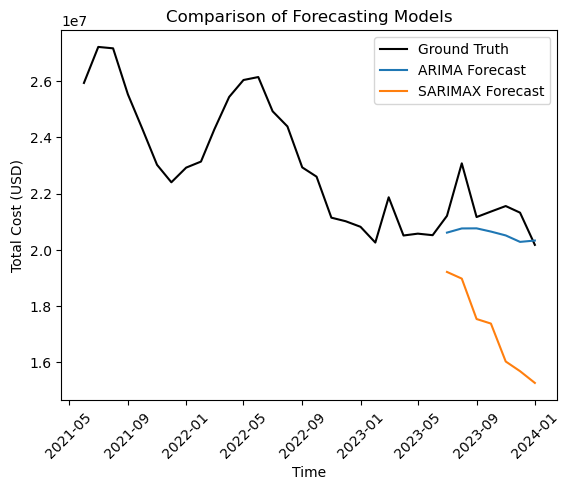

In [50]:
# Print RMSE for each model
print("ARIMA RMSE:", np.round(arima_rmse,2))
print("SARIMAX RMSE:", np.round(sarimax_rmse, 2))
print("ARIMA Relative RMSE:", np.round(arima_relative_rmse, 2))
print("SARIMAX Relative RMSE:", np.round(sarimax_relative_rmse, 2))

# Visualization
plt.figure()
plt.plot(dufresne_tsa['Year_Month'], dufresne_tsa['Amount_Allowed_6_month_avg'], label='Ground Truth', color='black')
plt.plot(test['Year_Month'], arima_forecast, label='ARIMA Forecast')
plt.plot(test['Year_Month'], sarimax_forecast, label='SARIMAX Forecast')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Total Cost (USD)')
plt.title('Comparison of Forecasting Models')
plt.legend()
plt.show()